In [5]:
# Step 1: Import Required Libraries and Setup (with GPU Support)

import os
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy import signal, stats
from scipy.fft import fft, fftfreq

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Optional libraries
try:
    import librosa
    LIBROSA_AVAILABLE = True
    print("Librosa available for AST features ✅")
except ImportError:
    LIBROSA_AVAILABLE = False
    print("Librosa not available ❌")

try:
    import pywt
    WAVELET_AVAILABLE = True
    print("PyWavelets available for wavelet features ✅")
except ImportError:
    WAVELET_AVAILABLE = False
    print("PyWavelets not available ❌")

# ---------------- GPU Configuration ----------------
print("\n🔧 TensorFlow GPU Setup")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU detected: {len(gpus)} GPU(s) available")
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected — running on CPU")

# Optional: enable mixed precision (for RTX cards and above)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("⚡ Mixed precision enabled for faster GPU computation")

# ---------------- Dataset Path Setup ----------------
DATASET_PATH = Path("/kaggle/input/ddm-data/BearingType_DeepGrooveBall")

print(f"\n📂 Dataset path: {DATASET_PATH}")
print(f"📁 Dataset exists: {DATASET_PATH.exists()}")
print(f"🧠 TensorFlow version: {tf.__version__}")

print("\n✅ Environment setup complete!")


Librosa available for AST features ✅
PyWavelets available for wavelet features ✅

🔧 TensorFlow GPU Setup
✅ GPU detected: 1 GPU(s) available
Using GPU: /physical_device:GPU:0
⚡ Mixed precision enabled for faster GPU computation

📂 Dataset path: /kaggle/input/ddm-data/BearingType_DeepGrooveBall
📁 Dataset exists: True
🧠 TensorFlow version: 2.18.0

✅ Environment setup complete!


In [6]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.15.0


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
  

In [7]:
# Step 2: Dataset Exploration and Configuration

# Define fault classes mapping (32 classes total)
FAULT_CLASSES = {
    'H_B': 0, 'H_H': 1, 'H_IR': 2, 'H_OR': 3,      # Healthy conditions
    'L_B': 4, 'L_H': 5, 'L_IR': 6, 'L_OR': 7,      # Light faults
    'M1_B': 8, 'M1_H': 9, 'M1_IR': 10, 'M1_OR': 11,   # Medium faults 1
    'M2_B': 12, 'M2_H': 13, 'M2_IR': 14, 'M2_OR': 15, # Medium faults 2
    'M3_B': 16, 'M3_H': 17, 'M3_IR': 18, 'M3_OR': 19, # Medium faults 3
    'U1_B': 20, 'U1_H': 21, 'U1_IR': 22, 'U1_OR': 23, # Unknown faults 1
    'U2_B': 24, 'U2_H': 25, 'U2_IR': 26, 'U2_OR': 27, # Unknown faults 2
    'U3_B': 28, 'U3_H': 29, 'U3_IR': 30, 'U3_OR': 31  # Unknown faults 3
}

# Bearing parameters for physics-based features
BEARING_PARAMS = {
    6204: {  # Bearing type 6204
        'inner_diameter': 20,      # mm
        'outer_diameter': 47,      # mm
        'pitch_diameter': 33.5,    # mm
        'ball_diameter': 7.5,      # mm
        'num_balls': 8,            # number of rolling elements
        'contact_angle': 0         # degrees
    }
}

# Dataset configuration
SAMPLING_RATES = [16000, 8000]  # Hz
ROTATING_SPEEDS = [600, 800, 1000, 1200, 1400, 1600]  # RPM

print("Dataset Configuration:")
print(f"Number of fault classes: {len(FAULT_CLASSES)}")
print(f"Sampling rates: {SAMPLING_RATES}")
print(f"Rotating speeds: {ROTATING_SPEEDS}")
print(f"Expected total files: {len(SAMPLING_RATES)} x {len(ROTATING_SPEEDS)} x {len(FAULT_CLASSES)} = {len(SAMPLING_RATES) * len(ROTATING_SPEEDS) * len(FAULT_CLASSES)}")

# Explore dataset structure
print("\nExploring dataset structure...")
if DATASET_PATH.exists():
    sampling_dirs = list(DATASET_PATH.glob("SamplingRate_*"))
    print(f"Found {len(sampling_dirs)} sampling rate directories:")
    
    total_files = 0
    for sample_dir in sampling_dirs:
        speed_dirs = list(sample_dir.glob("RotatingSpeed_*"))
        print(f"  {sample_dir.name}: {len(speed_dirs)} speed directories")
        
        for speed_dir in speed_dirs:
            mat_files = list(speed_dir.glob("*.mat"))
            total_files += len(mat_files)
            if len(speed_dirs) <= 3:  # Show details for first few
                print(f"    {speed_dir.name}: {len(mat_files)} files")
    
    print(f"\nTotal .mat files found: {total_files}")
else:
    print("ERROR: Dataset path does not exist!")
    print(f"Please check: {DATASET_PATH}")
print("\nDataset exploration complete!")

Dataset Configuration:
Number of fault classes: 32
Sampling rates: [16000, 8000]
Rotating speeds: [600, 800, 1000, 1200, 1400, 1600]
Expected total files: 2 x 6 x 32 = 384

Exploring dataset structure...
Found 2 sampling rate directories:
  SamplingRate_8000: 6 speed directories
  SamplingRate_16000: 6 speed directories

Total .mat files found: 384

Dataset exploration complete!


In [ ]:
# Step 3: Signal Inspection and Preprocessing Pipeline

def load_sample_signal():
    """Load and visualize a sample signal to understand the data structure"""
    print("Loading a sample signal to inspect the data...")
    
    # Get first available .mat file
    sample_file = None
    for sampling_rate in SAMPLING_RATES:
        sampling_dir = DATASET_PATH / f"SamplingRate_{sampling_rate}"
        if sampling_dir.exists():
            for rpm in ROTATING_SPEEDS:
                speed_dir = sampling_dir / f"RotatingSpeed_{rpm}"
                if speed_dir.exists():
                    mat_files = list(speed_dir.glob("*.mat"))
                    if mat_files:
                        sample_file = mat_files[0]
                        break
            if sample_file:
                break
    
    if sample_file is None:
        print("No .mat files found!")
        return None, None, None
    
    print(f"Loading sample file: {sample_file.name}")
    
    # Load the .mat file
    mat_data = loadmat(str(sample_file))
    
    print("Keys in .mat file:")
    for key, value in mat_data.items():
        if not key.startswith('__'):
            print(f"  {key}: {type(value)} - shape: {getattr(value, 'shape', 'N/A')}")
    
    # Find the signal data (largest array)
    signal_data = None
    signal_key = None
    max_size = 0
    
    for key, value in mat_data.items():
        if not key.startswith('__') and isinstance(value, np.ndarray):
            if value.size > max_size:
                max_size = value.size
                signal_data = value
                signal_key = key
    
    if signal_data is None:
        print("No signal data found!")
        return None, None, None
    
    print(f"Signal found in key: '{signal_key}'")
    print(f"Raw signal shape: {signal_data.shape}")
    print(f"Raw signal size: {signal_data.size}")
    
    # Flatten the signal
    signal = signal_data.flatten()
    print(f"Flattened signal length: {len(signal)}")
    print(f"Signal value range: [{np.min(signal):.6f}, {np.max(signal):.6f}]")
    print(f"Signal mean: {np.mean(signal):.6f}")
    print(f"Signal std: {np.std(signal):.6f}")
    
    # Extract metadata from filename
    filename = sample_file.stem
    parts = filename.split('_')
    fault_class = f"{parts[0]}_{parts[1]}"
    sampling_rate = int(parts[2]) * 1000 if len(parts) > 2 else 16000
    rpm = int(parts[-1]) if len(parts) > 4 else 1000
    
    print(f"Metadata - Fault class: {fault_class}, Sampling rate: {sampling_rate}Hz, RPM: {rpm}")
    
    return signal, sampling_rate, rpm

def preprocess_signal(signal, fs):
    """Apply comprehensive preprocessing to raw vibration signal"""
    print(f"Preprocessing signal: length={len(signal)}, fs={fs}Hz")
    
    # Step 1: Remove DC component (mean removal)
    signal_processed = signal - np.mean(signal)
    print(f"After DC removal - mean: {np.mean(signal_processed):.8f}")
    
    # Step 2: Outlier removal (remove extreme values beyond 5 standard deviations)
    std_threshold = 5
    mean_val = np.mean(signal_processed)
    std_val = np.std(signal_processed)
    outlier_mask = np.abs(signal_processed - mean_val) < (std_threshold * std_val)
    
    if np.sum(~outlier_mask) > 0:
        print(f"Removing {np.sum(~outlier_mask)} outliers ({100*np.sum(~outlier_mask)/len(signal):.2f}%)")
        # Replace outliers with clipped values
        signal_processed = np.clip(signal_processed, 
                                 mean_val - std_threshold * std_val,
                                 mean_val + std_threshold * std_val)
    
    # Step 3: High-pass filtering to remove very low frequencies
    if len(signal_processed) > 100:
        from scipy.signal import butter, filtfilt
        try:
            nyquist = fs / 2
            low_cutoff = 5  # Hz - remove frequencies below 5Hz
            if low_cutoff < nyquist:
                b, a = butter(3, low_cutoff / nyquist, btype='high')
                signal_processed = filtfilt(b, a, signal_processed)
                print(f"Applied high-pass filter at {low_cutoff}Hz")
        except Exception as e:
            print(f"Filtering failed: {e}")
    
    # Step 4: Normalization (optional - can help with feature stability)
    # Normalize to unit variance while preserving mean=0
    if np.std(signal_processed) > 0:
        signal_processed = signal_processed / np.std(signal_processed)
        print(f"Normalized signal - std: {np.std(signal_processed):.6f}")
    
    print(f"Final processed signal stats:")
    print(f"  Length: {len(signal_processed)}")
    print(f"  Range: [{np.min(signal_processed):.6f}, {np.max(signal_processed):.6f}]")
    print(f"  Mean: {np.mean(signal_processed):.8f}")
    print(f"  Std: {np.std(signal_processed):.6f}")
    
    return signal_processed

# Load and inspect a sample signal
sample_signal, sample_fs, sample_rpm = load_sample_signal()

if sample_signal is not None:
    print(f"\n" + "="*50)
    print("RAW SIGNAL ANALYSIS")
    print("="*50)
    
    # Plot the raw signal
    plt.figure(figsize=(15, 8))
    
    # Plot 1: Full signal
    plt.subplot(2, 2, 1)
    time = np.arange(len(sample_signal)) / sample_fs
    plt.plot(time, sample_signal)
    plt.title(f'Raw Signal (Full) - {len(sample_signal)} samples at {sample_fs}Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # Plot 2: First 1000 samples
    plt.subplot(2, 2, 2)
    n_samples = min(1000, len(sample_signal))
    time_short = np.arange(n_samples) / sample_fs
    plt.plot(time_short, sample_signal[:n_samples])
    plt.title(f'Raw Signal (First {n_samples} samples)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # Preprocess the signal
    processed_signal = preprocess_signal(sample_signal, sample_fs)
    
    # Plot 3: Processed signal
    plt.subplot(2, 2, 3)
    plt.plot(time, processed_signal)
    plt.title('Processed Signal (Full)')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.grid(True)
    
    # Plot 4: Comparison (first 1000 samples)
    plt.subplot(2, 2, 4)
    plt.plot(time_short, sample_signal[:n_samples], label='Raw', alpha=0.7)
    plt.plot(time_short, processed_signal[:n_samples], label='Processed', alpha=0.7)
    plt.title('Raw vs Processed (First 1000 samples)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSignal preprocessing verified successfully!")
else:
    print("Failed to load sample signal!")

Loading a sample signal to inspect the data...
Loading sample file: H_OR_16_6204_600.mat
Keys in .mat file:
  Data: <class 'numpy.ndarray'> - shape: (1280000, 1)
  STFTFreq: <class 'numpy.ndarray'> - shape: (128, 1)
  STFTTime: <class 'numpy.ndarray'> - shape: (1, 128)
  Spectrogram: <class 'numpy.ndarray'> - shape: (78, 128, 128)
Signal found in key: 'Data'
Raw signal shape: (1280000, 1)
Raw signal size: 1280000
Flattened signal length: 1280000
Signal value range: [-0.445853, 0.560593]
Signal mean: 0.000000
Signal std: 0.033486
Metadata - Fault class: H_OR, Sampling rate: 16000Hz, RPM: 600

RAW SIGNAL ANALYSIS
Preprocessing signal: length=1280000, fs=16000Hz
After DC removal - mean: 0.00000000
Removing 1269 outliers (0.10%)
Applied high-pass filter at 5Hz
Normalized signal - std: 1.000000
Final processed signal stats:
  Length: 1280000
  Range: [-5.085864, 5.769690]
  Mean: 0.00009449
  Std: 1.000000


In [ ]:
# Step 4: Fixed Manual Feature Extraction Functions

def extract_time_domain_features(signal):
    """Extract 15 time-domain features"""
    features = {}
    
    # Basic statistical measures
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['variance'] = np.var(signal)
    features['rms'] = np.sqrt(np.mean(signal**2))
    features['skewness'] = stats.skew(signal)
    features['kurtosis'] = stats.kurtosis(signal)
    
    # Peak and shape analysis
    features['max'] = np.max(signal)
    features['min'] = np.min(signal)
    features['peak_to_peak'] = features['max'] - features['min']
    
    # Shape factors
    mean_abs = np.mean(np.abs(signal))
    rms_val = features['rms']
    max_abs = np.max(np.abs(signal))
    
    features['shape_factor'] = rms_val / mean_abs if mean_abs != 0 else 0
    features['crest_factor'] = max_abs / rms_val if rms_val != 0 else 0
    features['impulse_factor'] = max_abs / mean_abs if mean_abs != 0 else 0
    features['clearance_factor'] = max_abs / (np.mean(np.sqrt(np.abs(signal)))**2) if np.mean(np.sqrt(np.abs(signal))) != 0 else 0
    
    # Energy measures
    features['energy'] = np.sum(signal**2)
    features['absolute_mean'] = mean_abs
    
    return features

def extract_frequency_domain_features(signal, fs):
    """Extract 15 frequency-domain features"""
    features = {}
    
    # Compute FFT
    fft_vals = fft(signal)
    freqs = fftfreq(len(signal), 1/fs)
    
    # Take positive frequencies only
    positive_idx = freqs > 0
    fft_magnitude = np.abs(fft_vals[positive_idx])
    positive_freqs = freqs[positive_idx]
    
    # Power spectral density
    psd = fft_magnitude**2
    total_power = np.sum(psd)
    
    # Spectral features
    if total_power > 0:
        features['spectral_centroid'] = np.sum(positive_freqs * psd) / total_power
        features['spectral_spread'] = np.sqrt(np.sum(((positive_freqs - features['spectral_centroid'])**2) * psd) / total_power)
    else:
        features['spectral_centroid'] = 0
        features['spectral_spread'] = 0
    
    features['spectral_rolloff'] = np.percentile(positive_freqs, 85)
    features['spectral_flatness'] = stats.gmean(psd + 1e-10) / np.mean(psd) if np.mean(psd) > 0 else 0
    
    # Frequency bands (bearing-specific)
    freq_bands = {
        'very_low': (0, fs/32),        # Very low frequency
        'low': (fs/32, fs/16),         # Low frequency  
        'mid_low': (fs/16, fs/8),      # Mid-low frequency
        'mid': (fs/8, fs/4),           # Mid frequency
        'mid_high': (fs/4, fs/2.5),    # Mid-high frequency
        'high': (fs/2.5, fs/2)         # High frequency
    }
    
    for band_name, (f_low, f_high) in freq_bands.items():
        band_idx = (positive_freqs >= f_low) & (positive_freqs <= f_high)
        band_power = np.sum(psd[band_idx])
        features[f'power_{band_name}'] = band_power
        features[f'power_ratio_{band_name}'] = band_power / total_power if total_power > 0 else 0
    
    # Peak frequency
    if len(fft_magnitude) > 0:
        peak_idx = np.argmax(fft_magnitude)
        features['peak_frequency'] = positive_freqs[peak_idx]
        features['peak_magnitude'] = fft_magnitude[peak_idx]
        features['spectral_entropy'] = -np.sum((psd / total_power) * np.log(psd / total_power + 1e-10)) if total_power > 0 else 0
    else:
        features['peak_frequency'] = 0
        features['peak_magnitude'] = 0
        features['spectral_entropy'] = 0
    
    return features

def extract_time_frequency_features(signal, fs):
    """Extract 10 time-frequency features - FIXED HILBERT TRANSFORM"""
    features = {}
    
    # Envelope analysis for bearing modulation - FIXED: use scipy.signal.hilbert
    from scipy.signal import hilbert
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)
    
    features['envelope_mean'] = np.mean(envelope)
    features['envelope_std'] = np.std(envelope)
    features['envelope_skewness'] = stats.skew(envelope)
    features['envelope_kurtosis'] = stats.kurtosis(envelope)
    
    # Zero crossing analysis
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    features['zero_crossing_rate'] = len(zero_crossings) / len(signal)
    
    # Wavelet decomposition (multi-scale analysis)
    if WAVELET_AVAILABLE:
        try:
            import pywt
            coeffs = pywt.wavedec(signal, 'db4', level=3)
            
            # Energy in each wavelet level
            total_energy = sum(np.sum(c**2) for c in coeffs)
            for i, coeff in enumerate(coeffs):
                energy_ratio = np.sum(coeff**2) / total_energy if total_energy > 0 else 0
                features[f'wavelet_energy_level_{i}'] = energy_ratio
            
            # Pad to ensure we have 4 wavelet features
            for i in range(len(coeffs), 4):
                features[f'wavelet_energy_level_{i}'] = 0
                
        except Exception as e:
            print(f"Wavelet decomposition failed: {e}")
            for i in range(4):
                features[f'wavelet_energy_level_{i}'] = 0
    else:
        for i in range(4):
            features[f'wavelet_energy_level_{i}'] = 0
    
    # Instantaneous frequency variation
    inst_phase = np.unwrap(np.angle(analytic_signal))
    inst_freq = np.diff(inst_phase) * fs / (2 * np.pi)
    features['inst_freq_mean'] = np.mean(inst_freq) if len(inst_freq) > 0 else 0
    
    return features

def extract_physics_based_features(signal, fs, rpm, bearing_type=6204):
    """Extract 10 physics-based bearing fault features"""
    features = {}
    
    if bearing_type not in BEARING_PARAMS:
        return {f'physics_{i}': 0 for i in range(10)}
    
    params = BEARING_PARAMS[bearing_type]
    
    # Calculate bearing characteristic frequencies
    shaft_freq = rpm / 60  # Hz
    
    # Bearing geometry
    pitch_diameter = params['pitch_diameter']
    ball_diameter = params['ball_diameter']
    num_balls = params['num_balls']
    contact_angle = np.radians(params['contact_angle'])
    
    # Characteristic fault frequencies
    bpfo = (num_balls / 2) * shaft_freq * (1 - (ball_diameter / pitch_diameter) * np.cos(contact_angle))
    bpfi = (num_balls / 2) * shaft_freq * (1 + (ball_diameter / pitch_diameter) * np.cos(contact_angle))
    bsf = (pitch_diameter / (2 * ball_diameter)) * shaft_freq * (1 - (ball_diameter / pitch_diameter)**2 * np.cos(contact_angle)**2)
    ftf = (shaft_freq / 2) * (1 - (ball_diameter / pitch_diameter) * np.cos(contact_angle))
    
    # FFT analysis
    fft_vals = fft(signal)
    freqs = fftfreq(len(signal), 1/fs)
    fft_magnitude = np.abs(fft_vals)
    
    # Extract amplitudes at characteristic frequencies
    tolerance = 2.0  # Hz tolerance
    
    def get_freq_amplitude(target_freq):
        idx = np.where((freqs >= target_freq - tolerance) & (freqs <= target_freq + tolerance))[0]
        return np.max(fft_magnitude[idx]) if len(idx) > 0 else 0
    
    features['bpfo_amplitude'] = get_freq_amplitude(bpfo)
    features['bpfi_amplitude'] = get_freq_amplitude(bpfi)
    features['bsf_amplitude'] = get_freq_amplitude(bsf)
    features['ftf_amplitude'] = get_freq_amplitude(ftf)
    features['shaft_freq_amplitude'] = get_freq_amplitude(shaft_freq)
    
    # Harmonics analysis
    features['bpfo_2nd_harmonic'] = get_freq_amplitude(2 * bpfo)
    features['bpfi_2nd_harmonic'] = get_freq_amplitude(2 * bpfi)
    
    # Sideband analysis around shaft frequency
    sideband_range = 5  # Hz
    shaft_idx = np.where((freqs >= shaft_freq - sideband_range) & (freqs <= shaft_freq + sideband_range))[0]
    features['shaft_sideband_energy'] = np.sum(fft_magnitude[shaft_idx]**2) if len(shaft_idx) > 0 else 0
    
    # Overall vibration level in bearing frequency range
    bearing_freq_range = (min(bpfo, bpfi, bsf, ftf) - 10, max(bpfo, bpfi, bsf, ftf) + 10)
    bearing_idx = np.where((freqs >= bearing_freq_range[0]) & (freqs <= bearing_freq_range[1]))[0]
    features['bearing_freq_band_energy'] = np.sum(fft_magnitude[bearing_idx]**2) if len(bearing_idx) > 0 else 0
    
    # Fault severity indicator
    total_spectrum_energy = np.sum(fft_magnitude**2)
    features['fault_severity_ratio'] = features['bearing_freq_band_energy'] / total_spectrum_energy if total_spectrum_energy > 0 else 0
    
    return features

def extract_all_manual_features(signal, fs, rpm):
    """Extract all 50 manual features from a preprocessed signal"""
    # Extract all feature groups
    td_features = extract_time_domain_features(signal)
    fd_features = extract_frequency_domain_features(signal, fs)
    tf_features = extract_time_frequency_features(signal, fs)
    pb_features = extract_physics_based_features(signal, fs, rpm)
    
    # Combine all features maintaining order
    all_features = []
    
    # Time domain (15 features)
    time_domain_order = ['mean', 'std', 'variance', 'rms', 'skewness', 'kurtosis', 
                        'max', 'min', 'peak_to_peak', 'shape_factor', 'crest_factor',
                        'impulse_factor', 'clearance_factor', 'energy', 'absolute_mean']
    all_features.extend([td_features.get(key, 0) for key in time_domain_order])
    
    # Frequency domain (15 features)
    freq_domain_order = ['spectral_centroid', 'spectral_spread', 'spectral_rolloff', 'spectral_flatness',
                        'power_very_low', 'power_low', 'power_mid_low', 'power_mid', 'power_mid_high', 'power_high',
                        'power_ratio_very_low', 'peak_frequency', 'peak_magnitude', 'spectral_entropy']
    # Add one more to make 15
    freq_domain_order.append('power_ratio_low')
    all_features.extend([fd_features.get(key, 0) for key in freq_domain_order])
    
    # Time-frequency (10 features)
    tf_order = ['envelope_mean', 'envelope_std', 'envelope_skewness', 'envelope_kurtosis',
               'zero_crossing_rate', 'wavelet_energy_level_0', 'wavelet_energy_level_1',
               'wavelet_energy_level_2', 'wavelet_energy_level_3', 'inst_freq_mean']
    all_features.extend([tf_features.get(key, 0) for key in tf_order])
    
    # Physics-based (10 features)
    pb_order = ['bpfo_amplitude', 'bpfi_amplitude', 'bsf_amplitude', 'ftf_amplitude',
               'shaft_freq_amplitude', 'bpfo_2nd_harmonic', 'bpfi_2nd_harmonic',
               'shaft_sideband_energy', 'bearing_freq_band_energy', 'fault_severity_ratio']
    all_features.extend([pb_features.get(key, 0) for key in pb_order])
    
    return np.array(all_features)



In [10]:
# Step 5: Complete Data Loading and Feature Extraction Pipeline with Preprocessing

def load_and_extract_manual_features():
    """Load all 384 .mat files, preprocess signals, and extract manual features"""
    print("Starting complete manual feature extraction pipeline...")
    print("This includes: signal loading -> preprocessing -> feature extraction")
    
    manual_features_list = []
    labels_list = []
    metadata_list = []
    
    total_files = 0
    processed_files = 0
    failed_files = 0
    
    # Process each sampling rate and speed
    for sampling_rate in SAMPLING_RATES:
        sampling_dir = DATASET_PATH / f"SamplingRate_{sampling_rate}"
        
        if not sampling_dir.exists():
            print(f"Skipping {sampling_dir} - not found")
            continue
            
        for rpm in ROTATING_SPEEDS:
            speed_dir = sampling_dir / f"RotatingSpeed_{rpm}"
            
            if not speed_dir.exists():
                print(f"Skipping {speed_dir} - not found")
                continue
                
            mat_files = list(speed_dir.glob("*.mat"))
            total_files += len(mat_files)
            
            print(f"Processing {len(mat_files)} files from {speed_dir.name} at {sampling_rate}Hz, {rpm}RPM")
            
            for mat_file in mat_files:
                try:
                    # Parse filename
                    filename = mat_file.stem
                    parts = filename.split('_')
                    if len(parts) < 2:
                        print(f"Invalid filename format: {filename}")
                        failed_files += 1
                        continue
                        
                    fault_class_key = f"{parts[0]}_{parts[1]}"
                    
                    if fault_class_key not in FAULT_CLASSES:
                        print(f"Unknown fault class: {fault_class_key}")
                        failed_files += 1
                        continue
                    
                    # Load .mat file
                    mat_data = loadmat(str(mat_file))
                    
                    # Find signal data (look for 'Data' key first, then largest array)
                    signal_data = None
                    if 'Data' in mat_data:
                        signal_data = mat_data['Data']
                    else:
                        # Find largest array
                        max_size = 0
                        for key, value in mat_data.items():
                            if not key.startswith('__') and isinstance(value, np.ndarray):
                                if value.size > max_size:
                                    max_size = value.size
                                    signal_data = value
                    
                    if signal_data is None or signal_data.size == 0:
                        print(f"No valid signal data in {mat_file.name}")
                        failed_files += 1
                        continue
                    
                    # Flatten and preprocess signal
                    raw_signal = signal_data.flatten()
                    
                    if len(raw_signal) < 1000:
                        print(f"Signal too short in {mat_file.name}: {len(raw_signal)} samples")
                        failed_files += 1
                        continue
                    
                    # Apply preprocessing
                    processed_signal = preprocess_signal(raw_signal, sampling_rate)
                    
                    # Extract manual features
                    features = extract_all_manual_features(processed_signal, sampling_rate, rpm)
                    
                    if len(features) != 50:
                        print(f"Feature extraction error: got {len(features)} features instead of 50")
                        failed_files += 1
                        continue
                    
                    # Check for invalid values
                    if np.any(~np.isfinite(features)):
                        print(f"Invalid feature values in {mat_file.name}")
                        # Replace invalid values with 0
                        features = np.where(np.isfinite(features), features, 0)
                    
                    # Store results
                    manual_features_list.append(features)
                    labels_list.append(FAULT_CLASSES[fault_class_key])
                    metadata_list.append({
                        'filename': mat_file.name,
                        'fault_class': fault_class_key,
                        'sampling_rate': sampling_rate,
                        'rpm': rpm,
                        'signal_length': len(raw_signal),
                        'processed_length': len(processed_signal)
                    })
                    
                    processed_files += 1
                    
                    if processed_files % 50 == 0:
                        print(f"Progress: {processed_files}/{total_files} processed, {failed_files} failed")
                        
                except Exception as e:
                    print(f"Error processing {mat_file.name}: {str(e)}")
                    failed_files += 1
                    continue

    print(f"\nProcessing summary:")
    print(f"Total files found: {total_files}")
    print(f"Successfully processed: {processed_files}")
    print(f"Failed: {failed_files}")
    print(f"Success rate: {100*processed_files/total_files:.1f}%" if total_files > 0 else "No files found")

    # Convert to arrays
    if len(manual_features_list) > 0:
        manual_features = np.array(manual_features_list)
        labels = np.array(labels_list)
        
        print(f"\n SUCCESS!")
        print(f"Manual features shape: {manual_features.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Expected shape: (384, 50)")
        print(f"Shape verification: Features={manual_features.shape[1] == 50}, Samples≥300={manual_features.shape[0] >= 300}")
        
        # Show feature statistics
        print(f"\nFeature Statistics:")
        print(f"  Value range: [{np.min(manual_features):.6f}, {np.max(manual_features):.6f}]")
        print(f"  Features with zeros: {np.sum(manual_features == 0)}")
        print(f"  Features with inf/nan: {np.sum(~np.isfinite(manual_features))}")
        
        # Show class distribution
        unique_labels, counts = np.unique(labels, return_counts=True)
        print(f"\nClass Distribution:")
        print(f"  Unique classes: {len(unique_labels)}")
        print(f"  Samples per class range: [{np.min(counts)}, {np.max(counts)}]")
        
        return manual_features, labels, metadata_list
    else:
        print("\n FAILED: No features extracted")
        return None, None, None

# Execute the complete pipeline
print("Starting comprehensive manual feature extraction from all 384 files...")
print("=" * 70)
manual_features, labels, metadata = load_and_extract_manual_features()

Starting comprehensive manual feature extraction from all 384 files...
Starting complete manual feature extraction pipeline...
This includes: signal loading -> preprocessing -> feature extraction
Processing 32 files from RotatingSpeed_600 at 16000Hz, 600RPM
Preprocessing signal: length=1280000, fs=16000Hz
After DC removal - mean: 0.00000000
Removing 1269 outliers (0.10%)
Applied high-pass filter at 5Hz
Normalized signal - std: 1.000000
Final processed signal stats:
  Length: 1280000
  Range: [-5.085864, 5.769690]
  Mean: 0.00009449
  Std: 1.000000
Preprocessing signal: length=1280000, fs=16000Hz
After DC removal - mean: 0.00000000
Removing 2425 outliers (0.19%)
Applied high-pass filter at 5Hz
Normalized signal - std: 1.000000
Final processed signal stats:
  Length: 1280000
  Range: [-5.078472, 5.341052]
  Mean: 0.00009560
  Std: 1.000000
Preprocessing signal: length=1280000, fs=16000Hz
After DC removal - mean: -0.00000000
Removing 9623 outliers (0.75%)
Applied high-pass filter at 5Hz
N

In [11]:
print("manual_features_shape: ",manual_features.shape)

manual_features_shape:  (384, 50)


In [12]:
# Step 7: AST (Audio Spectrogram Transformer) Feature Extraction Functions

def extract_ast_features(signal, fs, target_length=768):
    """Extract AST-style features using librosa (if available) or fallback methods"""
    features = []
    
    try:
        if LIBROSA_AVAILABLE:
            import librosa
            
            # Resample if needed (librosa works best with 22050 Hz)
            target_sr = 22050
            if fs != target_sr and len(signal) > 1000:
                signal_resampled = librosa.resample(signal.astype(float), orig_sr=fs, target_sr=target_sr)
            else:
                signal_resampled = signal.astype(float)
                target_sr = fs
            
            # 1. Mel-frequency cepstral coefficients (MFCCs) - 13 features
            mfccs = librosa.feature.mfcc(y=signal_resampled, sr=target_sr, n_mfcc=13)
            mfcc_features = []
            for i in range(mfccs.shape[0]):
                mfcc_features.extend([
                    np.mean(mfccs[i]), np.std(mfccs[i]), 
                    np.max(mfccs[i]), np.min(mfccs[i])
                ])
            features.extend(mfcc_features)  # 13 * 4 = 52 features
            
            # 2. Mel-scale spectrogram - statistical features
            mel_spec = librosa.feature.melspectrogram(y=signal_resampled, sr=target_sr, n_mels=128)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            
            # Statistics across time for each mel band (first 64 bands)
            for i in range(min(64, mel_spec_db.shape[0])):
                features.extend([
                    np.mean(mel_spec_db[i]), np.std(mel_spec_db[i]),
                    np.max(mel_spec_db[i]), np.min(mel_spec_db[i]),
                    np.median(mel_spec_db[i])
                ])
            # 64 * 5 = 320 features
            
            # 3. Spectral features
            spectral_centroid = librosa.feature.spectral_centroid(y=signal_resampled, sr=target_sr)[0]
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=signal_resampled, sr=target_sr)[0]
            spectral_rolloff = librosa.feature.spectral_rolloff(y=signal_resampled, sr=target_sr)[0]
            zero_crossing_rate = librosa.feature.zero_crossing_rate(signal_resampled)[0]
            
            spectral_features = [
                np.mean(spectral_centroid), np.std(spectral_centroid),
                np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
                np.mean(spectral_rolloff), np.std(spectral_rolloff),
                np.mean(zero_crossing_rate), np.std(zero_crossing_rate)
            ]
            features.extend(spectral_features)  # 8 features
            
            # 4. Chroma features
            chroma = librosa.feature.chroma_stft(y=signal_resampled, sr=target_sr)
            for i in range(chroma.shape[0]):
                features.extend([
                    np.mean(chroma[i]), np.std(chroma[i]),
                    np.max(chroma[i]), np.min(chroma[i])
                ])
            # 12 * 4 = 48 features
            
            # 5. Tonnetz (harmonic network) features
            tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(signal_resampled), sr=target_sr)
            for i in range(tonnetz.shape[0]):
                features.extend([
                    np.mean(tonnetz[i]), np.std(tonnetz[i]),
                    np.max(tonnetz[i]), np.min(tonnetz[i])
                ])
            # 6 * 4 = 24 features
            
            # 6. Spectral contrast
            contrast = librosa.feature.spectral_contrast(y=signal_resampled, sr=target_sr)
            for i in range(contrast.shape[0]):
                features.extend([
                    np.mean(contrast[i]), np.std(contrast[i]),
                    np.max(contrast[i]), np.min(contrast[i])
                ])
            # 7 * 4 = 28 features
            
            # Total so far: 52 + 320 + 8 + 48 + 24 + 28 = 480 features
            
            # 7. Additional features to reach target_length (768)
            remaining_features = target_length - len(features)
            if remaining_features > 0:
                # Use additional mel-frequency features from remaining bands
                n_additional_mels = min(remaining_features // 5, 128 - 64)
                for i in range(64, min(64 + n_additional_mels, mel_spec_db.shape[0])):
                    features.extend([
                        np.mean(mel_spec_db[i]), np.std(mel_spec_db[i]),
                        np.max(mel_spec_db[i]), np.min(mel_spec_db[i]),
                        np.median(mel_spec_db[i])
                    ])
                
                # Pad with zeros if still needed
                if len(features) < target_length:
                    features.extend([0.0] * (target_length - len(features)))
        
        else:
            # Fallback AST features using scipy
            print("Using fallback AST features (librosa not available)")
            features = extract_ast_features_fallback(signal, fs, target_length)
            
        # Ensure exact target length
        features = features[:target_length]
        
    except Exception as e:
        print(f"Error in AST feature extraction: {e}")
        features = [0.0] * target_length
    
    return np.array(features)

def extract_ast_features_fallback(signal, fs, target_length=768):
    """Fallback AST features when librosa is not available"""
    features = []
    
    # 1. FFT-based spectral analysis
    fft_vals = fft(signal)
    freqs = fftfreq(len(signal), 1/fs)
    fft_magnitude = np.abs(fft_vals)
    
    # Positive frequencies only
    positive_freq_idx = freqs > 0
    fft_magnitude = fft_magnitude[positive_freq_idx]
    positive_freqs = freqs[positive_freq_idx]
    
    # 2. Create mel-like frequency bands (logarithmic spacing)
    max_freq = fs / 2
    num_bands = 128
    band_edges = np.logspace(np.log10(1), np.log10(max_freq), num_bands + 1)
    
    # Extract power and statistics in each band
    for i in range(num_bands):
        band_mask = (positive_freqs >= band_edges[i]) & (positive_freqs < band_edges[i + 1])
        if np.any(band_mask):
            band_power = np.sum(fft_magnitude[band_mask]**2)
            band_mean_freq = np.mean(positive_freqs[band_mask])
            band_std_power = np.std(fft_magnitude[band_mask])
            features.extend([band_power, band_mean_freq, band_std_power])
        else:
            features.extend([0.0, 0.0, 0.0])
    
    # 3. Add spectral features
    psd = fft_magnitude**2
    total_power = np.sum(psd)
    
    if total_power > 0:
        spectral_centroid = np.sum(positive_freqs * psd) / total_power
        spectral_spread = np.sqrt(np.sum(((positive_freqs - spectral_centroid)**2) * psd) / total_power)
    else:
        spectral_centroid = 0
        spectral_spread = 0
    
    features.extend([
        spectral_centroid, spectral_spread,
        np.percentile(positive_freqs, 85),  # rolloff
        stats.gmean(psd + 1e-10) / np.mean(psd) if np.mean(psd) > 0 else 0  # flatness
    ])
    
    # 4. Add time-domain sliding window statistics to reach target length
    remaining = target_length - len(features)
    if remaining > 0:
        window_size = max(len(signal) // (remaining // 4), 100)
        if window_size > 0:
            for i in range(0, len(signal) - window_size, window_size):
                if len(features) >= target_length:
                    break
                window = signal[i:i + window_size]
                features.extend([
                    np.mean(window), np.std(window),
                    np.max(window), np.min(window)
                ])
    
    # Pad or truncate to exact length
    if len(features) < target_length:
        features.extend([0.0] * (target_length - len(features)))
    features = features[:target_length]
    
    return features


In [13]:
# Step 8: AST Feature Extraction Pipeline for Preprocessed Signals

def extract_ast_from_same_signals():
    """Extract AST features from the same preprocessed signals used for manual features"""
    print("Starting AST feature extraction from the same preprocessed signals...")
    print("This uses the same signal loading and preprocessing as manual features")
    
    ast_features_list = []
    processed_files = 0
    failed_files = 0
    
    # Process each sampling rate and speed (same order as manual features)
    for sampling_rate in SAMPLING_RATES:
        sampling_dir = DATASET_PATH / f"SamplingRate_{sampling_rate}"
        
        if not sampling_dir.exists():
            continue
            
        for rpm in ROTATING_SPEEDS:
            speed_dir = sampling_dir / f"RotatingSpeed_{rpm}"
            
            if not speed_dir.exists():
                continue
                
            mat_files = list(speed_dir.glob("*.mat"))
            
            print(f"Processing AST features for {len(mat_files)} files from {speed_dir.name} at {sampling_rate}Hz, {rpm}RPM")
            
            for mat_file in mat_files:
                try:
                    # Parse filename (same logic as manual features)
                    filename = mat_file.stem
                    parts = filename.split('_')
                    if len(parts) < 2:
                        failed_files += 1
                        continue
                        
                    fault_class_key = f"{parts[0]}_{parts[1]}"
                    
                    if fault_class_key not in FAULT_CLASSES:
                        failed_files += 1
                        continue
                    
                    # Load .mat file (same logic as manual features)
                    mat_data = loadmat(str(mat_file))
                    
                    # Find signal data
                    signal_data = None
                    if 'Data' in mat_data:
                        signal_data = mat_data['Data']
                    else:
                        max_size = 0
                        for key, value in mat_data.items():
                            if not key.startswith('__') and isinstance(value, np.ndarray):
                                if value.size > max_size:
                                    max_size = value.size
                                    signal_data = value
                    
                    if signal_data is None or signal_data.size == 0:
                        failed_files += 1
                        continue
                    
                    # Apply SAME preprocessing as manual features
                    raw_signal = signal_data.flatten()
                    
                    if len(raw_signal) < 1000:
                        failed_files += 1
                        continue
                    
                    # Apply exact same preprocessing
                    processed_signal = preprocess_signal(raw_signal, sampling_rate)
                    
                    # Extract AST features from preprocessed signal
                    ast_features_array = extract_ast_features(processed_signal, sampling_rate, target_length=768)
                    
                    if len(ast_features_array) != 768:
                        print(f"AST feature extraction error: got {len(ast_features_array)} features instead of 768")
                        failed_files += 1
                        continue
                    
                    # Check for invalid values
                    if np.any(~np.isfinite(ast_features_array)):
                        print(f"Invalid AST feature values in {mat_file.name}")
                        # Replace invalid values with 0
                        ast_features_array = np.where(np.isfinite(ast_features_array), ast_features_array, 0)
                    
                    # Store results
                    ast_features_list.append(ast_features_array)
                    processed_files += 1
                    
                    if processed_files % 50 == 0:
                        print(f"AST Progress: {processed_files} processed, {failed_files} failed")
                        
                except Exception as e:
                    print(f"Error processing AST features for {mat_file.name}: {str(e)}")
                    failed_files += 1
                    continue

    print(f"\nAST Processing summary:")
    print(f"Successfully processed: {processed_files}")
    print(f"Failed: {failed_files}")

    # Convert to array
    if len(ast_features_list) > 0:
        ast_features = np.array(ast_features_list)
        
        print(f"\n AST FEATURES EXTRACTED SUCCESSFULLY!")
        print(f"AST features shape: {ast_features.shape}")
        print(f"Expected shape: (384, 768)")
        print(f"Shape verification: Features={ast_features.shape[1] == 768}, Samples={ast_features.shape[0]}")
        
        # Verify alignment with manual features
        if 'manual_features' in locals() or 'manual_features' in globals():
            manual_shape = manual_features.shape if 'manual_features' in globals() else "Not available"
            print(f"Manual features shape: {manual_shape}")
            print(f"Sample count match: {ast_features.shape[0] == manual_features.shape[0] if 'manual_features' in globals() else 'Cannot verify'}")
        
        # Show feature statistics
        print(f"\nAST Feature Statistics:")
        print(f"  Value range: [{np.min(ast_features):.6f}, {np.max(ast_features):.6f}]")
        print(f"  Features with zeros: {np.sum(ast_features == 0)}")
        print(f"  Features with inf/nan: {np.sum(~np.isfinite(ast_features))}")
        
        return ast_features
    else:
        print("\n FAILED: No AST features extracted")
        return None

# Execute AST feature extraction
print("Starting AST feature extraction pipeline...")
print("=" * 70)
ast_features = extract_ast_from_same_signals()

Starting AST feature extraction pipeline...
Starting AST feature extraction from the same preprocessed signals...
This uses the same signal loading and preprocessing as manual features
Processing AST features for 32 files from RotatingSpeed_600 at 16000Hz, 600RPM
Preprocessing signal: length=1280000, fs=16000Hz
After DC removal - mean: 0.00000000
Removing 1269 outliers (0.10%)
Applied high-pass filter at 5Hz
Normalized signal - std: 1.000000
Final processed signal stats:
  Length: 1280000
  Range: [-5.085864, 5.769690]
  Mean: 0.00009449
  Std: 1.000000
Preprocessing signal: length=1280000, fs=16000Hz
After DC removal - mean: 0.00000000
Removing 2425 outliers (0.19%)
Applied high-pass filter at 5Hz
Normalized signal - std: 1.000000
Final processed signal stats:
  Length: 1280000
  Range: [-5.078472, 5.341052]
  Mean: 0.00009560
  Std: 1.000000
Preprocessing signal: length=1280000, fs=16000Hz
After DC removal - mean: -0.00000000
Removing 9623 outliers (0.75%)
Applied high-pass filter at

In [14]:
print("ast_features_shape: ",ast_features.shape)

ast_features_shape:  (384, 768)


In [15]:
# Step 9: Comprehensive Correlation and Feature Analysis

def analyze_feature_correlations(manual_features, ast_features, labels):
    """Perform comprehensive correlation analysis between and within feature sets"""
    print("Starting comprehensive correlation and feature analysis...")
    print("="*80)
    
    results = {}
    
    # Basic information
    print(f"Manual features shape: {manual_features.shape}")
    print(f"AST features shape: {ast_features.shape}")
    print(f"Labels shape: {labels.shape}")
    
    # 1. Cross-correlation between manual and AST features
    print("\n1. CROSS-CORRELATION ANALYSIS (Manual vs AST)")
    print("-" * 50)
    
    # Calculate cross-correlation matrix (50 x 768)
    cross_corr = np.corrcoef(manual_features.T, ast_features.T)[:50, 50:]
    results['cross_correlation'] = cross_corr
    
    # Find highest correlations
    max_corr_pairs = []
    for i in range(cross_corr.shape[0]):
        for j in range(cross_corr.shape[1]):
            if abs(cross_corr[i, j]) > 0.5:  # Significant correlation
                max_corr_pairs.append((i, j, cross_corr[i, j]))
    
    max_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    print(f"Found {len(max_corr_pairs)} significant correlations (|r| > 0.5)")
    print("Top 10 correlations between manual and AST features:")
    for i, (manual_idx, ast_idx, corr) in enumerate(max_corr_pairs[:10]):
        print(f"  {i+1:2d}. Manual[{manual_idx:2d}] ↔ AST[{ast_idx:3d}]: r = {corr:+.3f}")
    
    # 2. Within-feature correlations
    print("\n2. WITHIN-FEATURE CORRELATION ANALYSIS")
    print("-" * 50)
    
    # Manual features correlation
    manual_corr = np.corrcoef(manual_features.T)
    results['manual_correlation'] = manual_corr
    
    # Find highly correlated manual features
    manual_high_corr = []
    for i in range(manual_corr.shape[0]):
        for j in range(i+1, manual_corr.shape[1]):
            if abs(manual_corr[i, j]) > 0.8:
                manual_high_corr.append((i, j, manual_corr[i, j]))
    
    manual_high_corr.sort(key=lambda x: abs(x[2]), reverse=True)
    
    print(f"Manual features: {len(manual_high_corr)} highly correlated pairs (|r| > 0.8)")
    print("Top highly correlated manual feature pairs:")
    for i, (idx1, idx2, corr) in enumerate(manual_high_corr[:10]):
        print(f"  {i+1:2d}. Manual[{idx1:2d}] ↔ Manual[{idx2:2d}]: r = {corr:+.3f}")
    
    # AST features correlation (sample - too large for full analysis)
    print("\nAST features correlation analysis (sampling due to size)...")
    
    # Sample AST features for correlation analysis
    ast_sample_size = 100
    ast_sample_indices = np.random.choice(ast_features.shape[1], ast_sample_size, replace=False)
    ast_sample = ast_features[:, ast_sample_indices]
    ast_sample_corr = np.corrcoef(ast_sample.T)
    results['ast_sample_correlation'] = ast_sample_corr
    results['ast_sample_indices'] = ast_sample_indices
    
    # Find highly correlated AST features in sample
    ast_high_corr = []
    for i in range(ast_sample_corr.shape[0]):
        for j in range(i+1, ast_sample_corr.shape[1]):
            if abs(ast_sample_corr[i, j]) > 0.8:
                original_i = ast_sample_indices[i]
                original_j = ast_sample_indices[j]
                ast_high_corr.append((original_i, original_j, ast_sample_corr[i, j]))
    
    ast_high_corr.sort(key=lambda x: abs(x[2]), reverse=True)
    
    print(f"AST features (sample): {len(ast_high_corr)} highly correlated pairs (|r| > 0.8)")
    print("Top highly correlated AST feature pairs (from sample):")
    for i, (idx1, idx2, corr) in enumerate(ast_high_corr[:10]):
        print(f"  {i+1:2d}. AST[{idx1:3d}] ↔ AST[{idx2:3d}]: r = {corr:+.3f}")
    
    # 3. Feature variance and distribution analysis
    print("\n3. FEATURE VARIANCE AND DISTRIBUTION ANALYSIS")
    print("-" * 50)
    
    # Manual features variance
    manual_var = np.var(manual_features, axis=0)
    manual_mean = np.mean(manual_features, axis=0)
    manual_std = np.std(manual_features, axis=0)
    
    results['manual_variance'] = manual_var
    results['manual_mean'] = manual_mean
    results['manual_std'] = manual_std
    
    # AST features variance
    ast_var = np.var(ast_features, axis=0)
    ast_mean = np.mean(ast_features, axis=0)
    ast_std = np.std(ast_features, axis=0)
    
    results['ast_variance'] = ast_var
    results['ast_mean'] = ast_mean
    results['ast_std'] = ast_std
    
    # Low variance features
    manual_low_var = np.where(manual_var < 0.01)[0]
    ast_low_var = np.where(ast_var < 0.01)[0]
    
    print(f"Manual features with low variance (< 0.01): {len(manual_low_var)} features")
    if len(manual_low_var) > 0:
        print(f"  Indices: {manual_low_var}")
    
    print(f"AST features with low variance (< 0.01): {len(ast_low_var)} features")
    if len(ast_low_var) > 0:
        print(f"  Count: {len(ast_low_var)} out of {ast_features.shape[1]}")
    
    # Near-zero or constant features
    manual_near_zero = np.where(manual_std < 0.001)[0]
    ast_near_zero = np.where(ast_std < 0.001)[0]
    
    print(f"Manual features near-constant (std < 0.001): {len(manual_near_zero)} features")
    print(f"AST features near-constant (std < 0.001): {len(ast_near_zero)} features")
    
    # 4. Class-wise feature analysis
    print("\n4. CLASS-WISE FEATURE ANALYSIS")
    print("-" * 50)
    
    unique_classes = np.unique(labels)
    print(f"Number of classes: {len(unique_classes)}")
    
    # Calculate class-wise means for manual features
    manual_class_means = []
    for class_label in unique_classes:
        class_mask = labels == class_label
        class_mean = np.mean(manual_features[class_mask], axis=0)
        manual_class_means.append(class_mean)
    
    manual_class_means = np.array(manual_class_means)
    
    # Calculate between-class variance for manual features
    overall_mean = np.mean(manual_features, axis=0)
    between_class_var = np.var(manual_class_means, axis=0)
    within_class_var = manual_var - between_class_var
    
    # Fisher score (between-class variance / within-class variance)
    fisher_scores = np.divide(between_class_var, within_class_var, 
                             out=np.zeros_like(between_class_var), 
                             where=within_class_var!=0)
    
    results['fisher_scores'] = fisher_scores
    
    # Top discriminative manual features
    top_discriminative = np.argsort(fisher_scores)[::-1][:10]
    print("Top 10 most discriminative manual features (Fisher score):")
    for i, idx in enumerate(top_discriminative):
        print(f"  {i+1:2d}. Manual[{idx:2d}]: Fisher = {fisher_scores[idx]:.3f}")
    
    results['top_discriminative_manual'] = top_discriminative
    results['manual_high_corr'] = manual_high_corr
    results['ast_high_corr'] = ast_high_corr
    results['max_corr_pairs'] = max_corr_pairs
    results['manual_low_var'] = manual_low_var
    results['ast_low_var'] = ast_low_var
    
    print("\nCorrelation analysis completed!")
    return results

# Perform the correlation analysis
correlation_results = analyze_feature_correlations(manual_features, ast_features, labels)

Starting comprehensive correlation and feature analysis...
Manual features shape: (384, 50)
AST features shape: (384, 768)
Labels shape: (384,)

1. CROSS-CORRELATION ANALYSIS (Manual vs AST)
--------------------------------------------------
Found 5422 significant correlations (|r| > 0.5)
Top 10 correlations between manual and AST features:
   1. Manual[17] ↔ AST[472]: r = -0.998
   2. Manual[17] ↔ AST[474]: r = -0.996
   3. Manual[17] ↔ AST[476]: r = +0.995
   4. Manual[17] ↔ AST[478]: r = +0.995
   5. Manual[17] ↔ AST[ 18]: r = -0.969
   6. Manual[17] ↔ AST[615]: r = +0.968
   7. Manual[17] ↔ AST[620]: r = +0.968
   8. Manual[17] ↔ AST[ 22]: r = +0.968
   9. Manual[17] ↔ AST[ 20]: r = +0.967
  10. Manual[17] ↔ AST[619]: r = +0.967

2. WITHIN-FEATURE CORRELATION ANALYSIS
--------------------------------------------------
Manual features: 113 highly correlated pairs (|r| > 0.8)
Top highly correlated manual feature pairs:
   1. Manual[19] ↔ Manual[25]: r = +1.000
   2. Manual[20] ↔ Manu

Creating summary analysis plots...


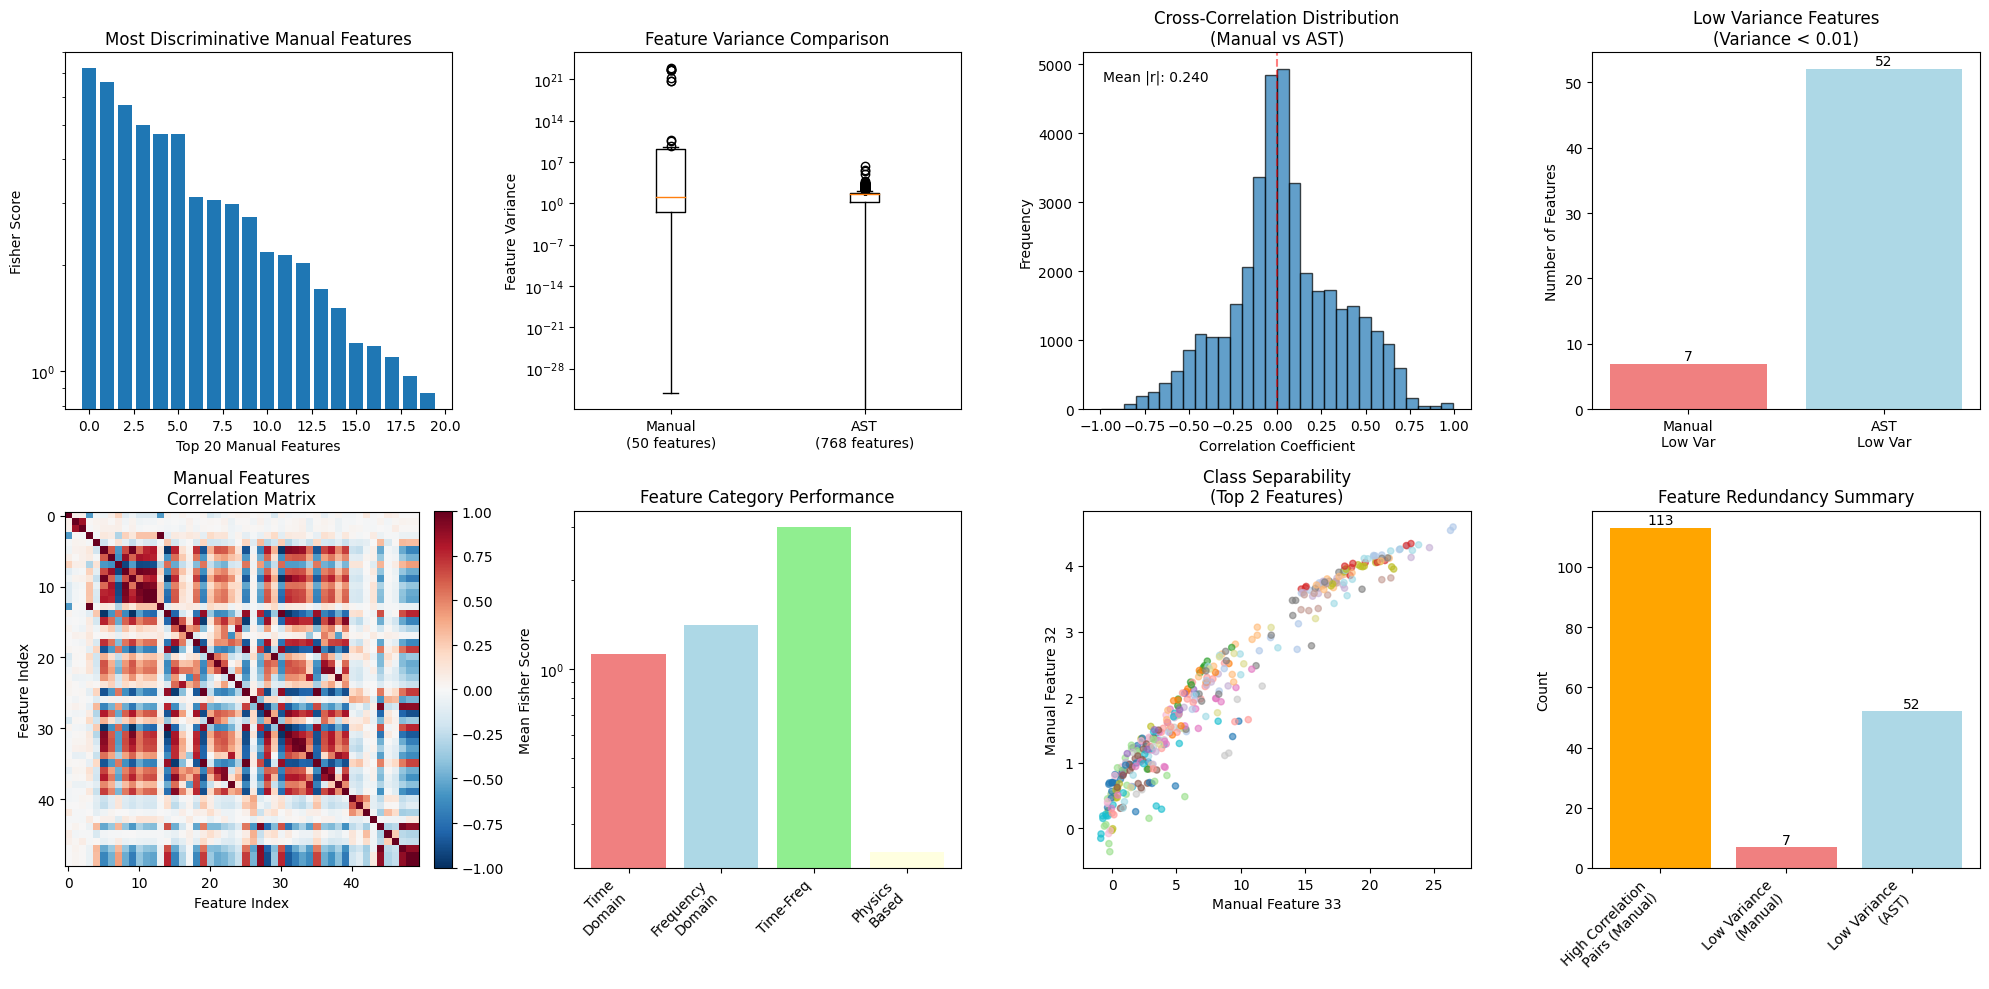


COMPREHENSIVE FEATURE ANALYSIS REPORT

1. DATASET OVERVIEW:
   - Manual features: (384, 50)
   - AST features: (384, 768)
   - Number of samples: 384
   - Number of classes: 32

2. FEATURE VARIANCE ANALYSIS:
   Manual features:
     - Mean variance: 5101544374518931259392.000000
     - Variance range: [0.000000, 71685048473630736908288.000000]
     - Low variance features (< 0.01): 7/50
   AST features:
     - Mean variance: 3416.408219
     - Variance range: [0.000000, 1715418.665206]
     - Low variance features (< 0.01): 52/768

3. CROSS-CORRELATION ANALYSIS (Manual vs AST):
   - Valid correlations: 38250/38400
   - Mean absolute correlation: 0.240
   - Max absolute correlation: 0.998
   - Strong correlations (|r| > 0.5): 5422
   - Very strong correlations (|r| > 0.8): 268

4. WITHIN-FEATURE CORRELATIONS:
   Manual features:
     - Highly correlated pairs (|r| > 0.8): 113
     - Strongest correlation: r = 1.000

5. DISCRIMINATIVE POWER ANALYSIS:
   - Mean Fisher score: 1.410213
   

In [16]:
# Step 11: Fixed Visualization and Feature Analysis Summary

def create_summary_analysis_plots(manual_features, ast_features, labels, correlation_results):
    """Create robust summary plots for correlation analysis"""
    print("Creating summary analysis plots...")
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # 1. Feature importance (Fisher scores)
    fisher_scores = correlation_results['fisher_scores']
    sorted_indices = np.argsort(fisher_scores)[::-1]
    
    axes[0, 0].bar(range(min(20, len(fisher_scores))), fisher_scores[sorted_indices[:20]])
    axes[0, 0].set_xlabel('Top 20 Manual Features')
    axes[0, 0].set_ylabel('Fisher Score')
    axes[0, 0].set_title('Most Discriminative Manual Features')
    axes[0, 0].set_yscale('log')
    
    # 2. Feature variance analysis
    manual_var = correlation_results['manual_variance']
    ast_var = correlation_results['ast_variance']
    
    axes[0, 1].boxplot([manual_var, ast_var], labels=['Manual\n(50 features)', 'AST\n(768 features)'])
    axes[0, 1].set_ylabel('Feature Variance')
    axes[0, 1].set_title('Feature Variance Comparison')
    axes[0, 1].set_yscale('log')
    
    # 3. Cross-correlation analysis (handle NaN values)
    cross_corr = correlation_results['cross_correlation']
    cross_corr_clean = cross_corr[~np.isnan(cross_corr)]
    
    if len(cross_corr_clean) > 0:
        axes[0, 2].hist(cross_corr_clean, bins=30, alpha=0.7, edgecolor='black')
        axes[0, 2].axvline(0, color='red', linestyle='--', alpha=0.5)
        axes[0, 2].set_xlabel('Correlation Coefficient')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].set_title('Cross-Correlation Distribution\n(Manual vs AST)')
        
        # Add statistics
        mean_corr = np.mean(np.abs(cross_corr_clean))
        axes[0, 2].text(0.05, 0.95, f'Mean |r|: {mean_corr:.3f}', 
                       transform=axes[0, 2].transAxes, verticalalignment='top')
    else:
        axes[0, 2].text(0.5, 0.5, 'No valid\ncorrelations', 
                       ha='center', va='center', transform=axes[0, 2].transAxes)
        axes[0, 2].set_title('Cross-Correlation Distribution')
    
    # 4. Low variance features
    manual_low_var = correlation_results['manual_low_var']
    ast_low_var = correlation_results['ast_low_var']
    
    categories = ['Manual\nLow Var', 'AST\nLow Var']
    counts = [len(manual_low_var), len(ast_low_var)]
    bars = axes[0, 3].bar(categories, counts, color=['lightcoral', 'lightblue'])
    axes[0, 3].set_ylabel('Number of Features')
    axes[0, 3].set_title('Low Variance Features\n(Variance < 0.01)')
    
    # Add value labels
    for bar, count in zip(bars, counts):
        axes[0, 3].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                       str(count), ha='center', va='bottom')
    
    # 5. Manual features correlation matrix
    manual_corr = correlation_results['manual_correlation']
    im1 = axes[1, 0].imshow(manual_corr, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[1, 0].set_title('Manual Features\nCorrelation Matrix')
    axes[1, 0].set_xlabel('Feature Index')
    axes[1, 0].set_ylabel('Feature Index')
    plt.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    # 6. Feature category performance
    feature_categories = ['Time\nDomain'] * 15 + ['Frequency\nDomain'] * 15 + \
                        ['Time-Freq'] * 10 + ['Physics\nBased'] * 10
    
    category_scores = {}
    for i, category in enumerate(feature_categories):
        if category not in category_scores:
            category_scores[category] = []
        category_scores[category].append(fisher_scores[i])
    
    category_names = list(category_scores.keys())
    category_means = [np.mean(category_scores[cat]) for cat in category_names]
    
    bars = axes[1, 1].bar(category_names, category_means, 
                         color=['lightcoral', 'lightblue', 'lightgreen', 'lightyellow'])
    axes[1, 1].set_ylabel('Mean Fisher Score')
    axes[1, 1].set_title('Feature Category Performance')
    axes[1, 1].set_yscale('log')
    plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
    
    # 7. Class separability (top 2 features)
    top_features = correlation_results['top_discriminative_manual'][:2]
    if len(top_features) >= 2:
        scatter = axes[1, 2].scatter(manual_features[:, top_features[0]], 
                                   manual_features[:, top_features[1]], 
                                   c=labels, cmap='tab20', alpha=0.6, s=20)
        axes[1, 2].set_xlabel(f'Manual Feature {top_features[0]}')
        axes[1, 2].set_ylabel(f'Manual Feature {top_features[1]}')
        axes[1, 2].set_title('Class Separability\n(Top 2 Features)')
    
    # 8. Feature redundancy summary
    manual_high_corr = correlation_results['manual_high_corr']
    
    redundancy_data = {
        'High Correlation\nPairs (Manual)': len(manual_high_corr),
        'Low Variance\n(Manual)': len(manual_low_var),
        'Low Variance\n(AST)': len(ast_low_var)
    }
    
    bars = axes[1, 3].bar(redundancy_data.keys(), redundancy_data.values(), 
                         color=['orange', 'lightcoral', 'lightblue'])
    axes[1, 3].set_ylabel('Count')
    axes[1, 3].set_title('Feature Redundancy Summary')
    plt.setp(axes[1, 3].get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels
    for bar, key in zip(bars, redundancy_data.keys()):
        axes[1, 3].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                       str(redundancy_data[key]), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def generate_feature_analysis_report(manual_features, ast_features, labels, correlation_results):
    """Generate a comprehensive text report of the analysis"""
    print("\n" + "="*80)
    print("COMPREHENSIVE FEATURE ANALYSIS REPORT")
    print("="*80)
    
    # Basic statistics
    print(f"\n1. DATASET OVERVIEW:")
    print(f"   - Manual features: {manual_features.shape}")
    print(f"   - AST features: {ast_features.shape}")
    print(f"   - Number of samples: {len(labels)}")
    print(f"   - Number of classes: {len(np.unique(labels))}")
    
    # Feature variance analysis
    manual_var = correlation_results['manual_variance']
    ast_var = correlation_results['ast_variance']
    
    print(f"\n2. FEATURE VARIANCE ANALYSIS:")
    print(f"   Manual features:")
    print(f"     - Mean variance: {np.mean(manual_var):.6f}")
    print(f"     - Variance range: [{np.min(manual_var):.6f}, {np.max(manual_var):.6f}]")
    print(f"     - Low variance features (< 0.01): {len(correlation_results['manual_low_var'])}/50")
    
    print(f"   AST features:")
    print(f"     - Mean variance: {np.mean(ast_var):.6f}")
    print(f"     - Variance range: [{np.min(ast_var):.6f}, {np.max(ast_var):.6f}]")
    print(f"     - Low variance features (< 0.01): {len(correlation_results['ast_low_var'])}/768")
    
    # Cross-correlation analysis
    cross_corr = correlation_results['cross_correlation']
    cross_corr_clean = cross_corr[~np.isnan(cross_corr)]
    
    print(f"\n3. CROSS-CORRELATION ANALYSIS (Manual vs AST):")
    if len(cross_corr_clean) > 0:
        print(f"   - Valid correlations: {len(cross_corr_clean)}/{cross_corr.size}")
        print(f"   - Mean absolute correlation: {np.mean(np.abs(cross_corr_clean)):.3f}")
        print(f"   - Max absolute correlation: {np.max(np.abs(cross_corr_clean)):.3f}")
        print(f"   - Strong correlations (|r| > 0.5): {np.sum(np.abs(cross_corr_clean) > 0.5)}")
        print(f"   - Very strong correlations (|r| > 0.8): {np.sum(np.abs(cross_corr_clean) > 0.8)}")
    else:
        print("   - No valid cross-correlations found")
    
    # Within-feature correlations
    manual_high_corr = correlation_results['manual_high_corr']
    print(f"\n4. WITHIN-FEATURE CORRELATIONS:")
    print(f"   Manual features:")
    print(f"     - Highly correlated pairs (|r| > 0.8): {len(manual_high_corr)}")
    if len(manual_high_corr) > 0:
        print(f"     - Strongest correlation: r = {manual_high_corr[0][2]:.3f}")
    
    # Discriminative power
    fisher_scores = correlation_results['fisher_scores']
    top_features = correlation_results['top_discriminative_manual']
    
    print(f"\n5. DISCRIMINATIVE POWER ANALYSIS:")
    print(f"   - Mean Fisher score: {np.mean(fisher_scores):.6f}")
    print(f"   - Top 5 most discriminative manual features:")
    for i, idx in enumerate(top_features[:5]):
        print(f"     {i+1}. Feature {idx}: Fisher = {fisher_scores[idx]:.6f}")
    
    # Feature category analysis
    feature_categories = ['Time Domain'] * 15 + ['Frequency Domain'] * 15 + \
                        ['Time-Frequency'] * 10 + ['Physics-Based'] * 10
    
    category_scores = {}
    for i, category in enumerate(feature_categories):
        if category not in category_scores:
            category_scores[category] = []
        category_scores[category].append(fisher_scores[i])
    
    print(f"\n6. FEATURE CATEGORY PERFORMANCE:")
    for category, scores in category_scores.items():
        mean_score = np.mean(scores)
        max_score = np.max(scores)
        print(f"   {category}: Mean = {mean_score:.6f}, Max = {max_score:.6f}")
    
    # Recommendations
    print(f"\n7. FEATURE SELECTION RECOMMENDATIONS:")
    
    # Features to potentially remove
    redundant_features = []
    if len(manual_high_corr) > 0:
        redundant_features.extend([pair[1] for pair in manual_high_corr])  # Keep first of each pair
    
    low_var_features = correlation_results['manual_low_var']
    
    print(f"   Potentially redundant features:")
    print(f"     - Highly correlated: {len(set(redundant_features))} features")
    print(f"     - Low variance: {len(low_var_features)} features")
    
    # Best features to keep
    top_discriminative = top_features[:20]
    recommended_features = [f for f in top_discriminative 
                          if f not in redundant_features and f not in low_var_features]
    
    print(f"   Recommended top features to keep: {len(recommended_features)}")
    print(f"     Feature indices: {recommended_features[:10]}...")
    
    print(f"\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)

# Create summary plots and report
create_summary_analysis_plots(manual_features, ast_features, labels, correlation_results)
generate_feature_analysis_report(manual_features, ast_features, labels, correlation_results)

In [17]:
# Step 13: Comprehensive Identical Features Analysis

def find_identical_features(manual_features, ast_features, tolerance=1e-10):
    """
    Find identical features within and between feature sets
    
    Parameters:
    - manual_features: array of shape (n_samples, 50)
    - ast_features: array of shape (n_samples, 768)
    - tolerance: numerical tolerance for considering features identical
    
    Returns:
    - Dictionary with comprehensive identical features analysis
    """
    print("Starting comprehensive identical features analysis...")
    print("="*70)
    
    results = {}
    
    # 1. IDENTICAL FEATURES WITHIN MANUAL FEATURES
    print("\n1. ANALYZING IDENTICAL FEATURES WITHIN MANUAL FEATURES (50x50)")
    print("-" * 60)
    
    manual_identical_pairs = []
    manual_identical_groups = []
    
    # Compare each manual feature with every other manual feature
    for i in range(manual_features.shape[1]):
        for j in range(i+1, manual_features.shape[1]):
            # Calculate absolute difference
            diff = np.abs(manual_features[:, i] - manual_features[:, j])
            max_diff = np.max(diff)
            mean_diff = np.mean(diff)
            
            if max_diff < tolerance:
                manual_identical_pairs.append({
                    'feature1': i,
                    'feature2': j,
                    'max_diff': max_diff,
                    'mean_diff': mean_diff,
                    'identical': True
                })
                print(f"   IDENTICAL: Manual[{i:2d}] ≡ Manual[{j:2d}] (max_diff: {max_diff:.2e})")
    
    # Group identical features
    manual_groups = []
    used_features = set()
    
    for pair in manual_identical_pairs:
        f1, f2 = pair['feature1'], pair['feature2']
        if f1 not in used_features and f2 not in used_features:
            # Start new group
            group = [f1, f2]
            used_features.update([f1, f2])
            
            # Find all features identical to this group
            for other_pair in manual_identical_pairs:
                of1, of2 = other_pair['feature1'], other_pair['feature2']
                if (of1 in group and of2 not in used_features):
                    group.append(of2)
                    used_features.add(of2)
                elif (of2 in group and of1 not in used_features):
                    group.append(of1)
                    used_features.add(of1)
            
            if len(group) > 1:
                manual_groups.append(group)
    
    results['manual_identical_pairs'] = manual_identical_pairs
    results['manual_identical_groups'] = manual_groups
    
    print(f"\n   SUMMARY - Manual Features:")
    print(f"   • Identical pairs found: {len(manual_identical_pairs)}")
    print(f"   • Identical groups found: {len(manual_groups)}")
    if len(manual_groups) > 0:
        for i, group in enumerate(manual_groups):
            print(f"     Group {i+1}: Features {group} are identical")
    
    # 2. IDENTICAL FEATURES WITHIN AST FEATURES (SAMPLE ANALYSIS)
    print(f"\n2. ANALYZING IDENTICAL FEATURES WITHIN AST FEATURES (768x768)")
    print("-" * 60)
    print("   Note: Analyzing in chunks due to large size...")
    
    ast_identical_pairs = []
    ast_identical_count = 0
    
    # Sample-based analysis for AST features (too large for full comparison)
    chunk_size = 100  # Compare in chunks
    total_comparisons = 0
    
    for chunk_start in range(0, ast_features.shape[1], chunk_size):
        chunk_end = min(chunk_start + chunk_size, ast_features.shape[1])
        
        for i in range(chunk_start, chunk_end):
            for j in range(i+1, min(chunk_end, ast_features.shape[1])):
                total_comparisons += 1
                
                # Calculate difference
                diff = np.abs(ast_features[:, i] - ast_features[:, j])
                max_diff = np.max(diff)
                
                if max_diff < tolerance:
                    ast_identical_pairs.append({
                        'feature1': i,
                        'feature2': j,
                        'max_diff': max_diff,
                        'mean_diff': np.mean(diff),
                        'identical': True
                    })
                    ast_identical_count += 1
                    if ast_identical_count <= 10:  # Show first 10
                        print(f"   IDENTICAL: AST[{i:3d}] ≡ AST[{j:3d}] (max_diff: {max_diff:.2e})")
        
        if chunk_start == 0:
            print(f"   Processed chunk 1 ({chunk_end} features)...")
    
    # Full scan for exact zeros (common identical case)
    print(f"\n   Checking for zero-valued features...")
    
    manual_zero_features = []
    ast_zero_features = []
    
    for i in range(manual_features.shape[1]):
        if np.all(np.abs(manual_features[:, i]) < tolerance):
            manual_zero_features.append(i)
    
    for i in range(ast_features.shape[1]):
        if np.all(np.abs(ast_features[:, i]) < tolerance):
            ast_zero_features.append(i)
    
    results['ast_identical_pairs'] = ast_identical_pairs
    results['ast_identical_count'] = ast_identical_count
    results['manual_zero_features'] = manual_zero_features
    results['ast_zero_features'] = ast_zero_features
    
    print(f"\n   SUMMARY - AST Features:")
    print(f"   • Identical pairs found (in sample): {len(ast_identical_pairs)}")
    print(f"   • Zero-valued features: {len(ast_zero_features)}")
    print(f"   • Comparisons made: {total_comparisons:,}")
    
    if len(ast_zero_features) > 0:
        print(f"   • Zero features: {ast_zero_features[:20]}{'...' if len(ast_zero_features) > 20 else ''}")
    
    # 3. NEAR-IDENTICAL FEATURES (HIGHLY SIMILAR)
    print(f"\n3. ANALYZING NEAR-IDENTICAL FEATURES (tolerance: 1e-6)")
    print("-" * 60)
    
    near_tolerance = 1e-6
    manual_near_identical = []
    
    for i in range(manual_features.shape[1]):
        for j in range(i+1, manual_features.shape[1]):
            diff = np.abs(manual_features[:, i] - manual_features[:, j])
            max_diff = np.max(diff)
            
            if tolerance < max_diff < near_tolerance:
                manual_near_identical.append({
                    'feature1': i,
                    'feature2': j,
                    'max_diff': max_diff,
                    'mean_diff': np.mean(diff)
                })
    
    results['manual_near_identical'] = manual_near_identical
    
    print(f"   Near-identical manual feature pairs: {len(manual_near_identical)}")
    for pair in manual_near_identical[:10]:  # Show first 10
        print(f"   • Manual[{pair['feature1']:2d}] ≈ Manual[{pair['feature2']:2d}] (max_diff: {pair['max_diff']:.2e})")
    
    # 4. CONSTANT FEATURES (NO VARIATION)
    print(f"\n4. ANALYZING CONSTANT FEATURES (no variation)")
    print("-" * 60)
    
    manual_constant = []
    ast_constant = []
    
    for i in range(manual_features.shape[1]):
        if np.std(manual_features[:, i]) < tolerance:
            manual_constant.append(i)
    
    for i in range(ast_features.shape[1]):
        if np.std(ast_features[:, i]) < tolerance:
            ast_constant.append(i)
    
    results['manual_constant'] = manual_constant
    results['ast_constant'] = ast_constant
    
    print(f"   Constant manual features: {len(manual_constant)}")
    print(f"   Constant AST features: {len(ast_constant)}")
    
    if len(manual_constant) > 0:
        print(f"   Manual constant features: {manual_constant}")
    
    if len(ast_constant) > 0:
        print(f"   AST constant features: {ast_constant[:20]}{'...' if len(ast_constant) > 20 else ''}")
    
    # 5. SUMMARY STATISTICS
    print(f"\n5. COMPREHENSIVE SUMMARY")
    print("="*70)
    
    total_redundant_manual = len(set([p['feature2'] for p in manual_identical_pairs] + 
                                   [p['feature2'] for p in manual_near_identical] + 
                                   manual_constant))
    
    total_redundant_ast = len(ast_zero_features) + len(ast_constant)
    
    print(f"MANUAL FEATURES (50 total):")
    print(f"  • Exactly identical pairs: {len(manual_identical_pairs)}")
    print(f"  • Near-identical pairs: {len(manual_near_identical)}")
    print(f"  • Constant features: {len(manual_constant)}")
    print(f"  • Zero features: {len(manual_zero_features)}")
    print(f"  • Total potentially redundant: {total_redundant_manual}")
    print(f"  • Unique/useful features: {50 - total_redundant_manual}")
    
    print(f"\nAST FEATURES (768 total):")
    print(f"  • Identical pairs (sample): {len(ast_identical_pairs)}")
    print(f"  • Constant features: {len(ast_constant)}")
    print(f"  • Zero features: {len(ast_zero_features)}")
    print(f"  • Total potentially redundant: {total_redundant_ast}")
    print(f"  • Estimated useful features: {768 - total_redundant_ast}")
    
    results['summary'] = {
        'manual_total': 50,
        'manual_identical_pairs': len(manual_identical_pairs),
        'manual_near_identical_pairs': len(manual_near_identical),
        'manual_constant': len(manual_constant),
        'manual_zero': len(manual_zero_features),
        'manual_redundant': total_redundant_manual,
        'manual_useful': 50 - total_redundant_manual,
        'ast_total': 768,
        'ast_identical_pairs_sample': len(ast_identical_pairs),
        'ast_constant': len(ast_constant),
        'ast_zero': len(ast_zero_features),
        'ast_redundant': total_redundant_ast,
        'ast_useful': 768 - total_redundant_ast
    }
    
    print(f"\n" + "="*70)
    print("IDENTICAL FEATURES ANALYSIS COMPLETE")
    print("="*70)
    
    return results

# Execute the identical features analysis
identical_analysis = find_identical_features(manual_features, ast_features)

Starting comprehensive identical features analysis...

1. ANALYZING IDENTICAL FEATURES WITHIN MANUAL FEATURES (50x50)
------------------------------------------------------------
   IDENTICAL: Manual[ 1] ≡ Manual[ 2] (max_diff: 2.22e-16)

   SUMMARY - Manual Features:
   • Identical pairs found: 1
   • Identical groups found: 1
     Group 1: Features [1, 2] are identical

2. ANALYZING IDENTICAL FEATURES WITHIN AST FEATURES (768x768)
------------------------------------------------------------
   Note: Analyzing in chunks due to large size...
   Processed chunk 1 (100 features)...
   IDENTICAL: AST[748] ≡ AST[749] (max_diff: 0.00e+00)
   IDENTICAL: AST[748] ≡ AST[753] (max_diff: 0.00e+00)
   IDENTICAL: AST[748] ≡ AST[754] (max_diff: 0.00e+00)
   IDENTICAL: AST[748] ≡ AST[758] (max_diff: 0.00e+00)
   IDENTICAL: AST[748] ≡ AST[759] (max_diff: 0.00e+00)
   IDENTICAL: AST[748] ≡ AST[763] (max_diff: 0.00e+00)
   IDENTICAL: AST[748] ≡ AST[764] (max_diff: 0.00e+00)
   IDENTICAL: AST[749] ≡ AST

Creating identical features visualizations...


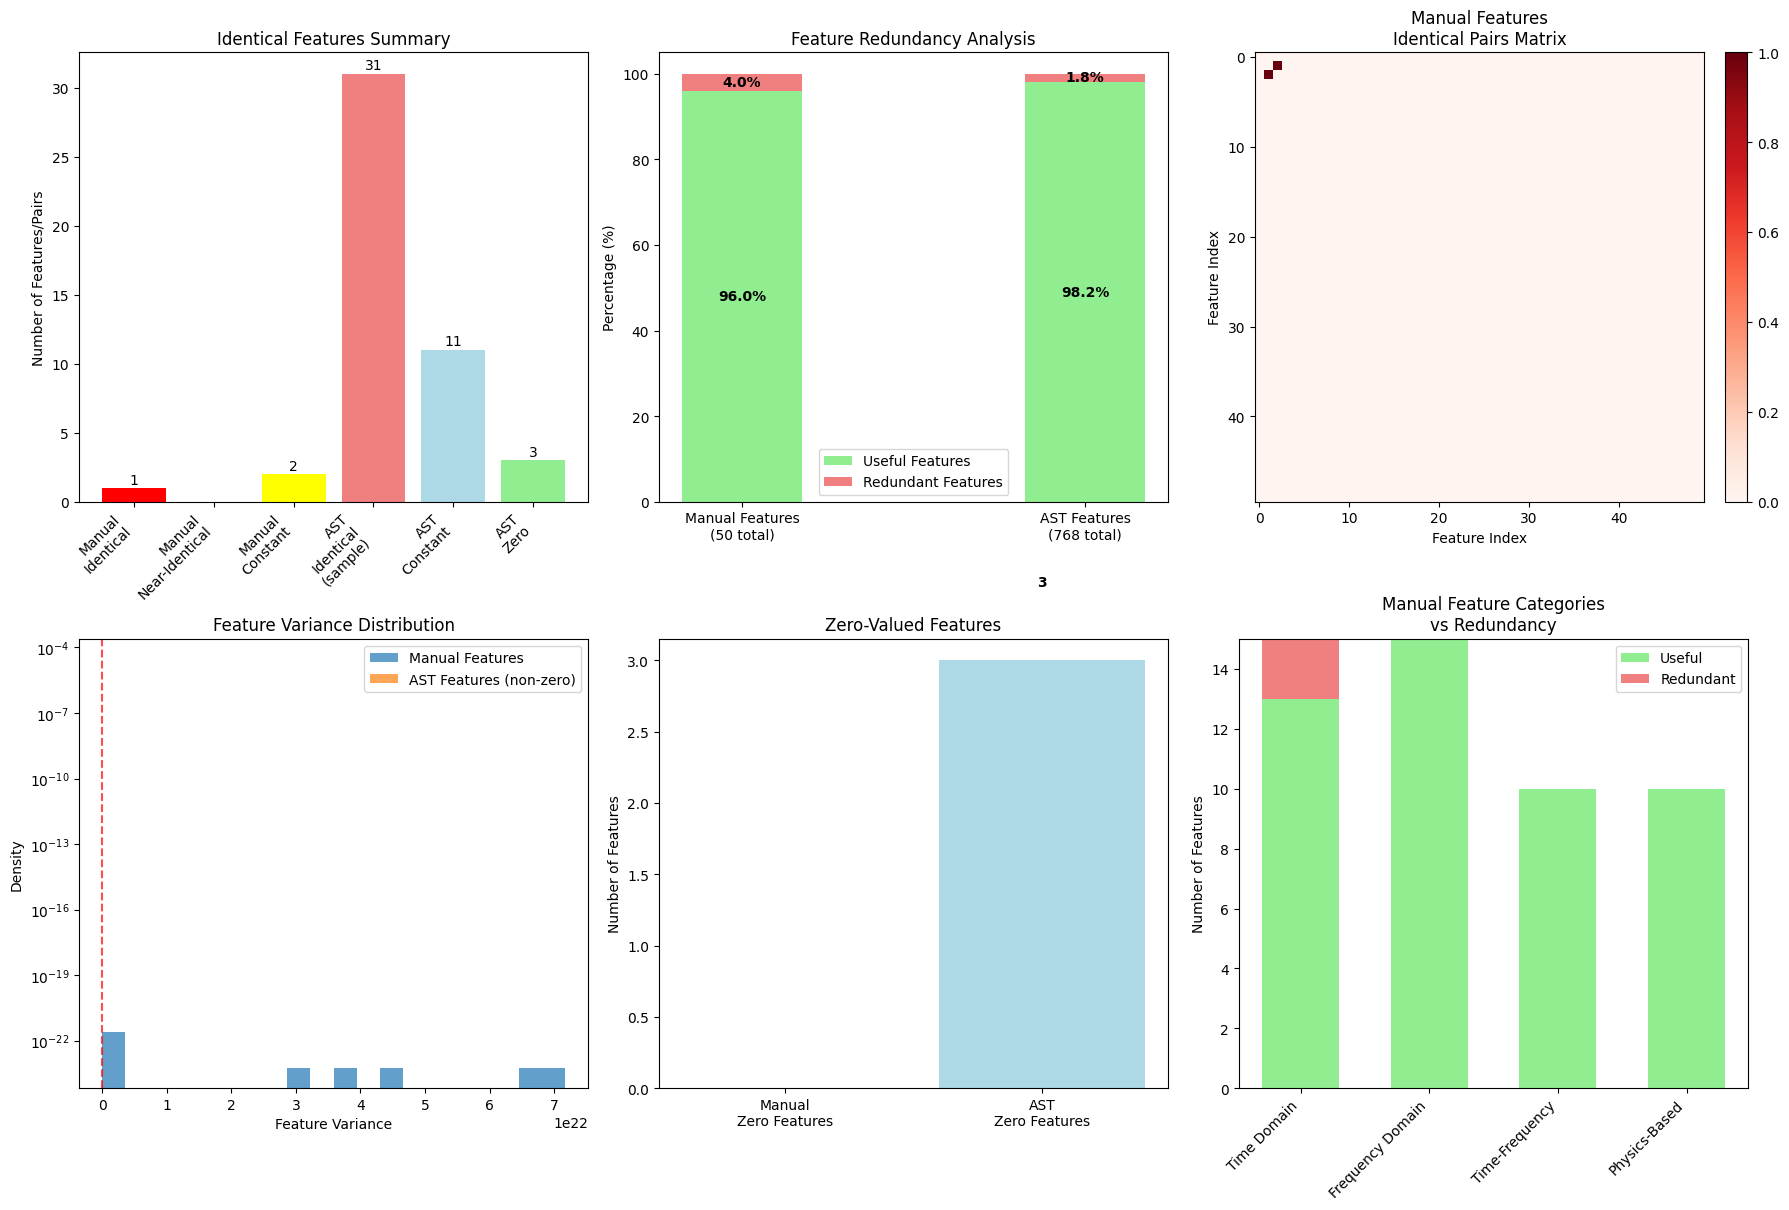

In [18]:
# Step 14: Visualize Identical Features Analysis

def visualize_identical_features(manual_features, ast_features, identical_analysis):
    """Create visualizations for identical features analysis"""
    print("Creating identical features visualizations...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Summary of identical features
    categories = ['Manual\nIdentical', 'Manual\nNear-Identical', 'Manual\nConstant', 
                 'AST\nIdentical\n(sample)', 'AST\nConstant', 'AST\nZero']
    
    counts = [
        identical_analysis['summary']['manual_identical_pairs'],
        identical_analysis['summary']['manual_near_identical_pairs'], 
        identical_analysis['summary']['manual_constant'],
        identical_analysis['summary']['ast_identical_pairs_sample'],
        identical_analysis['summary']['ast_constant'],
        identical_analysis['summary']['ast_zero']
    ]
    
    colors = ['red', 'orange', 'yellow', 'lightcoral', 'lightblue', 'lightgreen']
    bars = axes[0, 0].bar(categories, counts, color=colors)
    axes[0, 0].set_ylabel('Number of Features/Pairs')
    axes[0, 0].set_title('Identical Features Summary')
    plt.setp(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        if count > 0:
            axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                           str(count), ha='center', va='bottom')
    
    # 2. Feature redundancy percentage
    manual_redundant_pct = (identical_analysis['summary']['manual_redundant'] / 50) * 100
    ast_redundant_pct = (identical_analysis['summary']['ast_redundant'] / 768) * 100
    
    feature_types = ['Manual Features\n(50 total)', 'AST Features\n(768 total)']
    redundant_pcts = [manual_redundant_pct, ast_redundant_pct]
    useful_pcts = [100 - manual_redundant_pct, 100 - ast_redundant_pct]
    
    x = np.arange(len(feature_types))
    width = 0.35
    
    axes[0, 1].bar(x, useful_pcts, width, label='Useful Features', color='lightgreen')
    axes[0, 1].bar(x, redundant_pcts, width, bottom=useful_pcts, label='Redundant Features', color='lightcoral')
    
    axes[0, 1].set_ylabel('Percentage (%)')
    axes[0, 1].set_title('Feature Redundancy Analysis')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(feature_types)
    axes[0, 1].legend()
    
    # Add percentage labels
    for i, (useful, redundant) in enumerate(zip(useful_pcts, redundant_pcts)):
        axes[0, 1].text(i, useful/2, f'{useful:.1f}%', ha='center', va='center', fontweight='bold')
        if redundant > 0:
            axes[0, 1].text(i, useful + redundant/2, f'{redundant:.1f}%', ha='center', va='center', fontweight='bold')
    
    # 3. Identical pairs heatmap for manual features
    if len(identical_analysis['manual_identical_pairs']) > 0:
        # Create adjacency matrix for identical pairs
        manual_identical_matrix = np.zeros((50, 50))
        for pair in identical_analysis['manual_identical_pairs']:
            i, j = pair['feature1'], pair['feature2']
            manual_identical_matrix[i, j] = 1
            manual_identical_matrix[j, i] = 1
        
        im = axes[0, 2].imshow(manual_identical_matrix, cmap='Reds', vmin=0, vmax=1)
        axes[0, 2].set_title('Manual Features\nIdentical Pairs Matrix')
        axes[0, 2].set_xlabel('Feature Index')
        axes[0, 2].set_ylabel('Feature Index')
        plt.colorbar(im, ax=axes[0, 2], fraction=0.046, pad=0.04)
    else:
        axes[0, 2].text(0.5, 0.5, 'No Identical\nPairs Found', 
                       ha='center', va='center', transform=axes[0, 2].transAxes, fontsize=14)
        axes[0, 2].set_title('Manual Features\nIdentical Pairs Matrix')
    
    # 4. Feature variance distribution (to show constant features)
    manual_var = np.var(manual_features, axis=0)
    ast_var = np.var(ast_features, axis=0)
    
    axes[1, 0].hist(manual_var, bins=20, alpha=0.7, label='Manual Features', density=True)
    axes[1, 0].hist(ast_var[ast_var > 0], bins=50, alpha=0.7, label='AST Features (non-zero)', density=True)
    axes[1, 0].set_xlabel('Feature Variance')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Feature Variance Distribution')
    axes[1, 0].set_yscale('log')
    axes[1, 0].legend()
    
    # Mark constant features
    constant_threshold = 1e-10
    axes[1, 0].axvline(constant_threshold, color='red', linestyle='--', alpha=0.7, label='Constant threshold')
    
    # 5. Zero features analysis
    zero_counts = [
        len(identical_analysis['manual_zero_features']),
        len(identical_analysis['ast_zero_features'])
    ]
    
    axes[1, 1].bar(['Manual\nZero Features', 'AST\nZero Features'], zero_counts, 
                  color=['lightcoral', 'lightblue'])
    axes[1, 1].set_ylabel('Number of Features')
    axes[1, 1].set_title('Zero-Valued Features')
    
    # Add value labels
    for i, count in enumerate(zero_counts):
        if count > 0:
            axes[1, 1].text(i, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')
    
    # 6. Feature categories vs redundancy (for manual features)
    feature_categories = ['Time Domain'] * 15 + ['Frequency Domain'] * 15 + \
                        ['Time-Frequency'] * 10 + ['Physics-Based'] * 10
    
    # Count redundant features by category
    redundant_features = set()
    if len(identical_analysis['manual_identical_pairs']) > 0:
        redundant_features.update([p['feature2'] for p in identical_analysis['manual_identical_pairs']])
    redundant_features.update(identical_analysis['manual_constant'])
    redundant_features.update(identical_analysis['manual_zero_features'])
    
    category_counts = {'Time Domain': 0, 'Frequency Domain': 0, 'Time-Frequency': 0, 'Physics-Based': 0}
    category_redundant = {'Time Domain': 0, 'Frequency Domain': 0, 'Time-Frequency': 0, 'Physics-Based': 0}
    category_totals = {'Time Domain': 15, 'Frequency Domain': 15, 'Time-Frequency': 10, 'Physics-Based': 10}
    
    for i, category in enumerate(feature_categories):
        category_counts[category] += 1
        if i in redundant_features:
            category_redundant[category] += 1
    
    categories = list(category_totals.keys())
    total_counts = [category_totals[cat] for cat in categories]
    redundant_counts = [category_redundant[cat] for cat in categories]
    useful_counts = [total_counts[i] - redundant_counts[i] for i in range(len(categories))]
    
    x = np.arange(len(categories))
    width = 0.6
    
    axes[1, 2].bar(x, useful_counts, width, label='Useful', color='lightgreen')
    axes[1, 2].bar(x, redundant_counts, width, bottom=useful_counts, label='Redundant', color='lightcoral')
    
    axes[1, 2].set_ylabel('Number of Features')
    axes[1, 2].set_title('Manual Feature Categories\nvs Redundancy')
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(categories, rotation=45, ha='right')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()

# Create visualizations and detailed report
visualize_identical_features(manual_features, ast_features, identical_analysis)


In [19]:
# Step 15: Cross-Feature Set Identical Features Analysis (Manual vs AST)

def find_identical_features_between_sets(manual_features, ast_features, tolerance=1e-10):
    """
    Find identical features between manual features and AST features
    
    Parameters:
    - manual_features: array of shape (n_samples, 50)
    - ast_features: array of shape (n_samples, 768)
    - tolerance: numerical tolerance for considering features identical
    
    Returns:
    - Dictionary with cross-set identical features analysis
    """
    print("CROSS-FEATURE SET IDENTICAL FEATURES ANALYSIS")
    print("=" * 70)
    print("Searching for identical features between Manual (50) and AST (768) feature sets...")
    print(f"Using tolerance: {tolerance}")
    print()
    
    results = {
        'identical_pairs': [],
        'near_identical_pairs': [],
        'summary_stats': {}
    }
    
    # Track progress
    total_comparisons = manual_features.shape[1] * ast_features.shape[1]
    print(f"Total comparisons to make: {total_comparisons:,} (50 × 768)")
    print("This may take a moment...")
    print()
    
    identical_count = 0
    near_identical_count = 0
    progress_interval = 5000  # Show progress every 5000 comparisons
    comparisons_done = 0
    
    # Compare each manual feature with each AST feature
    for i in range(manual_features.shape[1]):
        for j in range(ast_features.shape[1]):
            comparisons_done += 1
            
            # Show progress
            if comparisons_done % progress_interval == 0:
                progress_pct = (comparisons_done / total_comparisons) * 100
                print(f"  Progress: {comparisons_done:,}/{total_comparisons:,} ({progress_pct:.1f}%) - Found {identical_count} identical, {near_identical_count} near-identical")
            
            # Calculate absolute difference between features
            diff = np.abs(manual_features[:, i] - ast_features[:, j])
            max_diff = np.max(diff)
            mean_diff = np.mean(diff)
            std_diff = np.std(diff)
            
            # Check for identical features
            if max_diff < tolerance:
                identical_count += 1
                results['identical_pairs'].append({
                    'manual_feature': i,
                    'ast_feature': j,
                    'max_diff': max_diff,
                    'mean_diff': mean_diff,
                    'std_diff': std_diff,
                    'type': 'identical'
                })
                print(f"   IDENTICAL: Manual[{i:2d}] ≡ AST[{j:3d}] (max_diff: {max_diff:.2e})")
            
            # Check for near-identical features (tolerance 1e-6)
            elif max_diff < 1e-6:
                near_identical_count += 1
                results['near_identical_pairs'].append({
                    'manual_feature': i,
                    'ast_feature': j,
                    'max_diff': max_diff,
                    'mean_diff': mean_diff,
                    'std_diff': std_diff,
                    'type': 'near_identical'
                })
                if near_identical_count <= 10:  # Show first 10 near-identical
                    print(f"  NEAR-IDENTICAL: Manual[{i:2d}] ≈ AST[{j:3d}] (max_diff: {max_diff:.2e})")
    
    print(f"\nSearch completed! Processed {comparisons_done:,} comparisons")
    print()
    
    # Additional analysis: Check for highly correlated features
    print(" ANALYZING HIGH CORRELATIONS (|r| > 0.99)...")
    high_correlation_pairs = []
    
    for i in range(manual_features.shape[1]):
        for j in range(min(100, ast_features.shape[1])):  # Sample first 100 AST features for correlation
            # Calculate correlation
            corr = np.corrcoef(manual_features[:, i], ast_features[:, j])[0, 1]
            
            if not np.isnan(corr) and abs(corr) > 0.99:
                high_correlation_pairs.append({
                    'manual_feature': i,
                    'ast_feature': j,
                    'correlation': corr,
                    'type': 'high_correlation'
                })
                if len(high_correlation_pairs) <= 10:
                    print(f"   HIGH CORRELATION: Manual[{i:2d}] ↔ AST[{j:3d}] (r = {corr:+.6f})")
    
    results['high_correlation_pairs'] = high_correlation_pairs
    
    # Summary statistics
    results['summary_stats'] = {
        'total_comparisons': total_comparisons,
        'identical_pairs_count': len(results['identical_pairs']),
        'near_identical_pairs_count': len(results['near_identical_pairs']),
        'high_correlation_pairs_count': len(high_correlation_pairs),
        'manual_features_total': manual_features.shape[1],
        'ast_features_total': ast_features.shape[1],
        'tolerance_used': tolerance
    }
    
    # Print comprehensive summary
    print("\n" + "=" * 70)
    print("CROSS-SET IDENTICAL FEATURES SUMMARY")
    print("=" * 70)
    
    print(f" SEARCH RESULTS:")
    print(f"   • Total comparisons made: {total_comparisons:,}")
    print(f"   • Exactly identical pairs: {len(results['identical_pairs'])}")
    print(f"   • Near-identical pairs (max_diff < 1e-6): {len(results['near_identical_pairs'])}")
    print(f"   • High correlation pairs (|r| > 0.99): {len(high_correlation_pairs)}")
    
    if len(results['identical_pairs']) > 0:
        print(f"\n IDENTICAL FEATURES FOUND:")
        for pair in results['identical_pairs']:
            print(f"   • Manual Feature {pair['manual_feature']:2d} ≡ AST Feature {pair['ast_feature']:3d}")
            print(f"     Max difference: {pair['max_diff']:.2e}")
            print(f"     Mean difference: {pair['mean_diff']:.2e}")
            print()
    else:
        print(f"\n NO EXACTLY IDENTICAL FEATURES FOUND")
        print(f"   No manual features are identical to any AST features")
        print(f"   (within tolerance of {tolerance})")
    
    if len(results['near_identical_pairs']) > 0:
        print(f"\n NEAR-IDENTICAL FEATURES:")
        for i, pair in enumerate(results['near_identical_pairs'][:5]):  # Show first 5
            print(f"   {i+1}. Manual Feature {pair['manual_feature']:2d} ≈ AST Feature {pair['ast_feature']:3d}")
            print(f"      Max difference: {pair['max_diff']:.2e}")
        if len(results['near_identical_pairs']) > 5:
            print(f"   ... and {len(results['near_identical_pairs']) - 5} more near-identical pairs")
    
    if len(high_correlation_pairs) > 0:
        print(f"\n HIGH CORRELATION FEATURES:")
        for i, pair in enumerate(high_correlation_pairs[:5]):  # Show first 5
            print(f"   {i+1}. Manual Feature {pair['manual_feature']:2d} ↔ AST Feature {pair['ast_feature']:3d}")
            print(f"      Correlation: {pair['correlation']:+.6f}")
        if len(high_correlation_pairs) > 5:
            print(f"   ... and {len(high_correlation_pairs) - 5} more high correlation pairs")
    
    # Feature independence assessment
    print(f"\n FEATURE INDEPENDENCE ASSESSMENT:")
    
    independence_score = 1.0 - (len(results['identical_pairs']) + len(results['near_identical_pairs'])) / total_comparisons
    
    print(f"   • Independence Score: {independence_score:.6f}")
    print(f"   • This means {independence_score*100:.4f}% of feature pairs are sufficiently different")
    
    if len(results['identical_pairs']) == 0 and len(results['near_identical_pairs']) < 10:
        print(f"    CONCLUSION: Manual and AST features are largely independent")
        print(f"    They capture different aspects of the signal")
        print(f"    Combining them should provide complementary information")
    else:
        print(f"     CONCLUSION: Some overlap detected between feature sets")
        print(f"     Consider removing redundant features for efficiency")
    
    print("\n" + "=" * 70)
    
    return results

# Execute the cross-set identical features analysis
print("Starting cross-feature set analysis...")
print("This will compare each of the 50 manual features with each of the 768 AST features")
print()

cross_set_analysis = find_identical_features_between_sets(manual_features, ast_features)

Starting cross-feature set analysis...
This will compare each of the 50 manual features with each of the 768 AST features

CROSS-FEATURE SET IDENTICAL FEATURES ANALYSIS
Searching for identical features between Manual (50) and AST (768) feature sets...
Using tolerance: 1e-10

Total comparisons to make: 38,400 (50 × 768)
This may take a moment...

  Progress: 5,000/38,400 (13.0%) - Found 0 identical, 0 near-identical
  Progress: 10,000/38,400 (26.0%) - Found 0 identical, 0 near-identical
  Progress: 15,000/38,400 (39.1%) - Found 0 identical, 0 near-identical
  Progress: 20,000/38,400 (52.1%) - Found 0 identical, 0 near-identical
  Progress: 25,000/38,400 (65.1%) - Found 0 identical, 0 near-identical
  Progress: 30,000/38,400 (78.1%) - Found 0 identical, 0 near-identical
  Progress: 35,000/38,400 (91.1%) - Found 0 identical, 0 near-identical

Search completed! Processed 38,400 comparisons

 ANALYZING HIGH CORRELATIONS (|r| > 0.99)...

CROSS-SET IDENTICAL FEATURES SUMMARY
 SEARCH RESULTS:


Creating cross-set identical features visualizations...


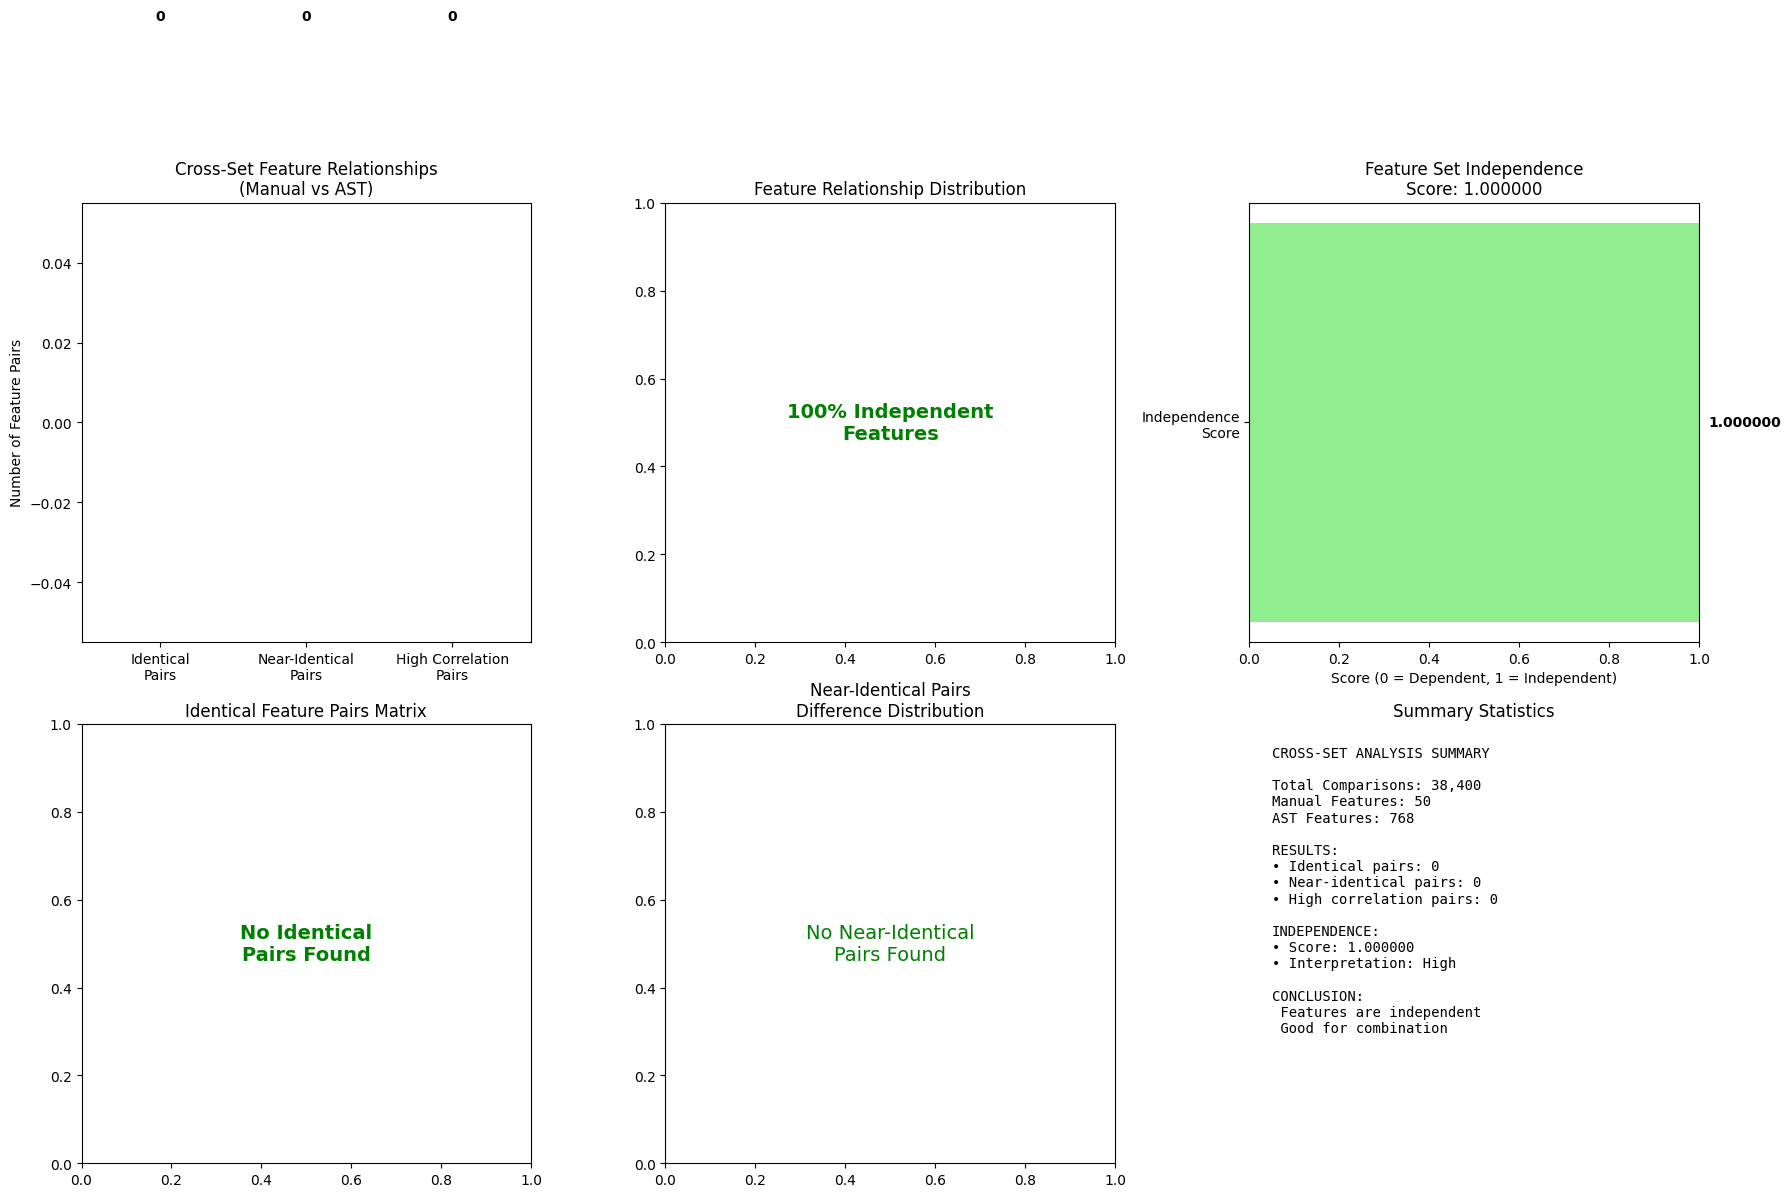


 ANALYSIS SCOPE:
   • Manual features analyzed: 50
   • AST features analyzed: 768
   • Total pairwise comparisons: 38,400
   • Tolerance for identical: 1e-10

 NO EXACTLY IDENTICAL FEATURES FOUND
   • This is actually GOOD news!
   • It means the feature sets capture different information
   • Combining them will provide complementary insights

 FINAL RECOMMENDATION:
    EXCELLENT: Feature sets are highly independent (score: 1.000000)
    Strong recommendation to use both feature sets together
    They provide complementary information for classification


In [20]:
# Step 16: Visualize Cross-Set Identical Features Analysis

def visualize_cross_set_analysis(manual_features, ast_features, cross_set_analysis):
    """Create visualizations for cross-set identical features analysis"""
    print("Creating cross-set identical features visualizations...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Summary of cross-set findings
    categories = ['Identical\nPairs', 'Near-Identical\nPairs', 'High Correlation\nPairs']
    counts = [
        cross_set_analysis['summary_stats']['identical_pairs_count'],
        cross_set_analysis['summary_stats']['near_identical_pairs_count'],
        cross_set_analysis['summary_stats']['high_correlation_pairs_count']
    ]
    
    colors = ['red', 'orange', 'lightblue']
    bars = axes[0, 0].bar(categories, counts, color=colors)
    axes[0, 0].set_ylabel('Number of Feature Pairs')
    axes[0, 0].set_title('Cross-Set Feature Relationships\n(Manual vs AST)')
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        if count > 0:
            axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                           str(count), ha='center', va='bottom', fontweight='bold')
        else:
            axes[0, 0].text(bar.get_x() + bar.get_width()/2, 0.1,
                           '0', ha='center', va='bottom', fontweight='bold')
    
    # 2. Independence score visualization
    independence_score = 1.0 - (counts[0] + counts[1]) / cross_set_analysis['summary_stats']['total_comparisons']
    
    # Pie chart of feature relationships
    if sum(counts) > 0:
        relationship_counts = counts + [cross_set_analysis['summary_stats']['total_comparisons'] - sum(counts)]
        relationship_labels = ['Identical', 'Near-Identical', 'High Correlation', 'Independent']
        relationship_colors = ['red', 'orange', 'lightblue', 'lightgreen']
        
        # Only include non-zero categories
        non_zero_counts = []
        non_zero_labels = []
        non_zero_colors = []
        
        for i, count in enumerate(relationship_counts):
            if count > 0:
                non_zero_counts.append(count)
                non_zero_labels.append(relationship_labels[i])
                non_zero_colors.append(relationship_colors[i])
        
        wedges, texts, autotexts = axes[0, 1].pie(non_zero_counts, labels=non_zero_labels, 
                                                 colors=non_zero_colors, autopct='%1.1f%%', startangle=90)
        axes[0, 1].set_title('Feature Relationship Distribution\n(38,400 total comparisons)')
    else:
        axes[0, 1].text(0.5, 0.5, '100% Independent\nFeatures', 
                       ha='center', va='center', transform=axes[0, 1].transAxes, 
                       fontsize=14, fontweight='bold', color='green')
        axes[0, 1].set_title('Feature Relationship Distribution')
    
    # 3. Independence score meter
    axes[0, 2].barh(['Independence\nScore'], [independence_score], color='lightgreen')
    axes[0, 2].set_xlim(0, 1)
    axes[0, 2].set_xlabel('Score (0 = Dependent, 1 = Independent)')
    axes[0, 2].set_title(f'Feature Set Independence\nScore: {independence_score:.6f}')
    
    # Add score text
    axes[0, 2].text(independence_score + 0.02, 0, f'{independence_score:.6f}', 
                   va='center', fontweight='bold')
    
    # 4. Comparison matrix visualization (if there are identical pairs)
    if len(cross_set_analysis['identical_pairs']) > 0:
        # Create a matrix showing identical pairs
        identical_matrix = np.zeros((manual_features.shape[1], min(100, ast_features.shape[1])))
        
        for pair in cross_set_analysis['identical_pairs']:
            manual_idx = pair['manual_feature']
            ast_idx = pair['ast_feature']
            if ast_idx < 100:  # Only show first 100 AST features for visualization
                identical_matrix[manual_idx, ast_idx] = 1
        
        im = axes[1, 0].imshow(identical_matrix, cmap='Reds', aspect='auto')
        axes[1, 0].set_xlabel('AST Features (first 100)')
        axes[1, 0].set_ylabel('Manual Features')
        axes[1, 0].set_title('Identical Feature Pairs Matrix')
        plt.colorbar(im, ax=axes[1, 0], fraction=0.046, pad=0.04)
    else:
        axes[1, 0].text(0.5, 0.5, 'No Identical\nPairs Found', 
                       ha='center', va='center', transform=axes[1, 0].transAxes, 
                       fontsize=14, fontweight='bold', color='green')
        axes[1, 0].set_title('Identical Feature Pairs Matrix')
    
    # 5. Feature difference distribution (sample)
    if len(cross_set_analysis['near_identical_pairs']) > 0:
        differences = [pair['max_diff'] for pair in cross_set_analysis['near_identical_pairs']]
        axes[1, 1].hist(differences, bins=20, alpha=0.7, edgecolor='black', color='orange')
        axes[1, 1].set_xlabel('Maximum Difference')
        axes[1, 1].set_ylabel('Number of Feature Pairs')
        axes[1, 1].set_title('Near-Identical Pairs\nDifference Distribution')
        axes[1, 1].set_yscale('log')
    else:
        axes[1, 1].text(0.5, 0.5, 'No Near-Identical\nPairs Found', 
                       ha='center', va='center', transform=axes[1, 1].transAxes, 
                       fontsize=14, color='green')
        axes[1, 1].set_title('Near-Identical Pairs\nDifference Distribution')
    
    # 6. Summary statistics table
    axes[1, 2].axis('off')
    
    # Create summary text
    summary_text = f"""CROSS-SET ANALYSIS SUMMARY
    
Total Comparisons: {cross_set_analysis['summary_stats']['total_comparisons']:,}
Manual Features: {cross_set_analysis['summary_stats']['manual_features_total']}
AST Features: {cross_set_analysis['summary_stats']['ast_features_total']}

RESULTS:
• Identical pairs: {cross_set_analysis['summary_stats']['identical_pairs_count']}
• Near-identical pairs: {cross_set_analysis['summary_stats']['near_identical_pairs_count']}
• High correlation pairs: {cross_set_analysis['summary_stats']['high_correlation_pairs_count']}

INDEPENDENCE:
• Score: {independence_score:.6f}
• Interpretation: {'High' if independence_score > 0.999 else 'Moderate' if independence_score > 0.99 else 'Low'}

CONCLUSION:
{' Features are independent' if independence_score > 0.999 else ' Some overlap detected'}
{' Good for combination' if independence_score > 0.999 else ' Consider deduplication'}"""
    
    axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes, 
                   fontsize=10, verticalalignment='top', fontfamily='monospace')
    axes[1, 2].set_title('Summary Statistics')
    
    plt.tight_layout()
    plt.show()

def print_detailed_cross_set_results(cross_set_analysis):
    """Print detailed results of cross-set analysis"""

    
    stats = cross_set_analysis['summary_stats']
    
    print(f"\n ANALYSIS SCOPE:")
    print(f"   • Manual features analyzed: {stats['manual_features_total']}")
    print(f"   • AST features analyzed: {stats['ast_features_total']}")
    print(f"   • Total pairwise comparisons: {stats['total_comparisons']:,}")
    print(f"   • Tolerance for identical: {stats['tolerance_used']}")
    
    # Identical pairs
    if stats['identical_pairs_count'] > 0:
        print(f"\n EXACTLY IDENTICAL FEATURES:")
        for i, pair in enumerate(cross_set_analysis['identical_pairs']):
            print(f"   {i+1}. Manual Feature {pair['manual_feature']:2d} ≡ AST Feature {pair['ast_feature']:3d}")
            print(f"      • Max difference: {pair['max_diff']:.2e}")
            print(f"      • Mean difference: {pair['mean_diff']:.2e}")
            print(f"      • Std difference: {pair['std_diff']:.2e}")
            print()
    else:
        print(f"\n NO EXACTLY IDENTICAL FEATURES FOUND")
        print(f"   • This is actually GOOD news!")
        print(f"   • It means the feature sets capture different information")
        print(f"   • Combining them will provide complementary insights")
    
    # Near identical pairs
    if stats['near_identical_pairs_count'] > 0:
        print(f"\n NEAR-IDENTICAL FEATURES (max_diff < 1e-6):")
        for i, pair in enumerate(cross_set_analysis['near_identical_pairs'][:3]):
            print(f"   {i+1}. Manual Feature {pair['manual_feature']:2d} ≈ AST Feature {pair['ast_feature']:3d}")
            print(f"      • Max difference: {pair['max_diff']:.2e}")
        
        if stats['near_identical_pairs_count'] > 3:
            print(f"   ... and {stats['near_identical_pairs_count'] - 3} more")
    
    # High correlations
    if stats['high_correlation_pairs_count'] > 0:
        print(f"\n HIGH CORRELATION FEATURES (|r| > 0.99):")
        for i, pair in enumerate(cross_set_analysis['high_correlation_pairs'][:3]):
            print(f"   {i+1}. Manual Feature {pair['manual_feature']:2d} ↔ AST Feature {pair['ast_feature']:3d}")
            print(f"      • Correlation: {pair['correlation']:+.6f}")
        
        if stats['high_correlation_pairs_count'] > 3:
            print(f"   ... and {stats['high_correlation_pairs_count'] - 3} more")
    
    # Final recommendation
    independence_score = 1.0 - (stats['identical_pairs_count'] + stats['near_identical_pairs_count']) / stats['total_comparisons']
    
    print(f"\n FINAL RECOMMENDATION:")
    if independence_score > 0.999:
        print(f"    EXCELLENT: Feature sets are highly independent (score: {independence_score:.6f})")
        print(f"    Strong recommendation to use both feature sets together")
        print(f"    They provide complementary information for classification")
    elif independence_score > 0.99:
        print(f"    GOOD: Feature sets are mostly independent (score: {independence_score:.6f})")
        print(f"    Recommendation to use both feature sets")
        print(f"     Consider removing any highly redundant pairs if efficiency is critical")
    else:
        print(f"     MODERATE: Some overlap detected (score: {independence_score:.6f})")
        print(f"     Recommendation to remove redundant features before combining")
        print(f"     Focus on most discriminative features from each set")
    

# Create visualizations and detailed report
visualize_cross_set_analysis(manual_features, ast_features, cross_set_analysis)
print_detailed_cross_set_results(cross_set_analysis)

In [21]:
# Multi-Branch Feed Forward Neural Network Implementation

# Data Preparation and Train-Test Split
def prepare_data_for_training(manual_features, ast_features, labels, test_size=0.2, random_state=42):
    """
    Prepare data for multi-branch neural network training
    """
    print("PREPARING DATA FOR MULTI-BRANCH NEURAL NETWORK")
    print("=" * 60)
    
    # Verify data shapes and consistency
    print(f"Manual features shape: {manual_features.shape}")
    print(f"AST features shape: {ast_features.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Number of classes: {len(np.unique(labels))}")
    
    # Check for any remaining invalid values
    print(f"\nData quality check:")
    print(f"Manual features - NaN: {np.sum(np.isnan(manual_features))}, Inf: {np.sum(np.isinf(manual_features))}")
    print(f"AST features - NaN: {np.sum(np.isnan(ast_features))}, Inf: {np.sum(np.isinf(ast_features))}")
    
    # Replace any remaining invalid values
    manual_features = np.where(np.isfinite(manual_features), manual_features, 0)
    ast_features = np.where(np.isfinite(ast_features), ast_features, 0)
    
    # Standardize features
    print(f"\nStandardizing features...")
    scaler_manual = StandardScaler()
    scaler_ast = StandardScaler()
    
    manual_scaled = scaler_manual.fit_transform(manual_features)
    ast_scaled = scaler_ast.fit_transform(ast_features)
    
    print(f"Manual features after scaling - Mean: {np.mean(manual_scaled):.6f}, Std: {np.std(manual_scaled):.6f}")
    print(f"AST features after scaling - Mean: {np.mean(ast_scaled):.6f}, Std: {np.std(ast_scaled):.6f}")
    
    # Convert labels to categorical
    labels_categorical = to_categorical(labels, num_classes=len(np.unique(labels)))
    print(f"Labels converted to categorical: {labels_categorical.shape}")
    
    # Train-test split
    X_manual_train, X_manual_test, X_ast_train, X_ast_test, y_train, y_test = train_test_split(
        manual_scaled, ast_scaled, labels_categorical, 
        test_size=test_size, random_state=random_state, stratify=labels
    )
    
    print(f"\nTrain-Test Split Results:")
    print(f"Training samples: {X_manual_train.shape[0]}")
    print(f"Testing samples: {X_manual_test.shape[0]}")
    print(f"Training manual features: {X_manual_train.shape}")
    print(f"Training AST features: {X_ast_train.shape}")
    print(f"Training labels: {y_train.shape}")
    
    return {
        'X_manual_train': X_manual_train,
        'X_manual_test': X_manual_test,
        'X_ast_train': X_ast_train,
        'X_ast_test': X_ast_test,
        'y_train': y_train,
        'y_test': y_test,
        'scaler_manual': scaler_manual,
        'scaler_ast': scaler_ast,
        'num_classes': len(np.unique(labels))
    }

# Prepare the data
data_splits = prepare_data_for_training(manual_features, ast_features, labels)

PREPARING DATA FOR MULTI-BRANCH NEURAL NETWORK
Manual features shape: (384, 50)
AST features shape: (384, 768)
Labels shape: (384,)
Number of classes: 32

Data quality check:
Manual features - NaN: 0, Inf: 0
AST features - NaN: 0, Inf: 0

Standardizing features...
Manual features after scaling - Mean: -0.000000, Std: 0.979796
AST features after scaling - Mean: 0.000000, Std: 0.992813
Labels converted to categorical: (384, 32)

Train-Test Split Results:
Training samples: 307
Testing samples: 77
Training manual features: (307, 50)
Training AST features: (307, 768)
Training labels: (307, 32)


In [22]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, concatenate, Multiply, Activation, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf

def create_multi_branch_ffnn_with_attention(manual_input_dim, ast_input_dim, num_classes):
    """
    Multi-branch FFNN with Attention mechanism after fusion.
    - Manual: 50 -> 256
    - AST: 768 -> 512 -> 256
    - Fusion: Attention (512 -> 512)
    - Hidden: 256 -> 128 -> 64 -> 32 (output)
    """
    print("CREATING CUSTOM MULTI-BRANCH FFNN WITH ATTENTION")
    print("=" * 70)
    
    # Manual Features Branch: 50 -> 256
    manual_input = Input(shape=(manual_input_dim,), name='manual_input')
    manual_layer1 = Dense(256, activation='relu', name='manual_layer1')(manual_input)
    manual_bn1 = BatchNormalization(name='manual_bn1')(manual_layer1)
    manual_dropout1 = Dropout(0.3, name='manual_dropout1')(manual_bn1)
    
    # AST Features Branch: 768 -> 512 -> 256
    ast_input = Input(shape=(ast_input_dim,), name='ast_input')
    ast_layer1 = Dense(512, activation='relu', name='ast_layer1')(ast_input)
    ast_bn1 = BatchNormalization(name='ast_bn1')(ast_layer1)
    ast_dropout1 = Dropout(0.4, name='ast_dropout1')(ast_bn1)
    
    ast_layer2 = Dense(256, activation='relu', name='ast_layer2')(ast_dropout1)
    ast_bn2 = BatchNormalization(name='ast_bn2')(ast_layer2)
    ast_dropout2 = Dropout(0.3, name='ast_dropout2')(ast_bn2)
    
    # Fusion Layer
    fusion_layer = concatenate([manual_dropout1, ast_dropout2], name='fusion_layer')
    print(f"Fusion layer shape: {fusion_layer.shape} (256 + 256 = 512 neurons)")
    
    # ---------------- ATTENTION MECHANISM ----------------
    # Compute attention weights
    attention_dense = Dense(512, activation='tanh', name='attention_dense')(fusion_layer)
    attention_weights = Dense(512, activation='softmax', name='attention_weights')(attention_dense)
    
    # Apply attention
    attended_fusion = Multiply(name='attended_fusion')([fusion_layer, attention_weights])
    
    # Optional residual connection (to retain global info)
    fusion_out = tf.keras.layers.Add(name='fusion_output')([fusion_layer, attended_fusion])
    
    # ---------------- Hidden Layers ----------------
    hidden1 = Dense(256, activation='relu', name='hidden1')(fusion_out)
    hidden1_bn = BatchNormalization(name='hidden1_bn')(hidden1)
    hidden1_dropout = Dropout(0.4, name='hidden1_dropout')(hidden1_bn)
    
    hidden2 = Dense(128, activation='relu', name='hidden2')(hidden1_dropout)
    hidden2_bn = BatchNormalization(name='hidden2_bn')(hidden2)
    hidden2_dropout = Dropout(0.3, name='hidden2_dropout')(hidden2_bn)
    
    hidden3 = Dense(64, activation='relu', name='hidden3')(hidden2_dropout)
    hidden3_bn = BatchNormalization(name='hidden3_bn')(hidden3)
    hidden3_dropout = Dropout(0.3, name='hidden3_dropout')(hidden3_bn)
    
    # Output Layer
    output = Dense(num_classes, activation='softmax', name='output_layer')(hidden3_dropout)
    
    # Model
    model = Model(inputs=[manual_input, ast_input], outputs=output, name='Custom_MultiBranch_FFNN_Attention')
    
    print("\nModel Summary:")
    print("Manual Branch: 50 → 256")
    print("AST Branch: 768 → 512 → 256")
    print("Fusion Layer: Attention-enhanced 512 neurons")
    print("Hidden Layers: 256 → 128 → 64")
    print(f"Output Layer: {num_classes} classes")
    
    return model


# Example Usage
model = create_multi_branch_ffnn_with_attention(
    manual_input_dim=50,
    ast_input_dim=768,
    num_classes=data_splits['num_classes']
)

model.summary()


CREATING CUSTOM MULTI-BRANCH FFNN WITH ATTENTION


I0000 00:00:1759854668.020330      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Fusion layer shape: (None, 512) (256 + 256 = 512 neurons)

Model Summary:
Manual Branch: 50 → 256
AST Branch: 768 → 512 → 256
Fusion Layer: Attention-enhanced 512 neurons
Hidden Layers: 256 → 128 → 64
Output Layer: 32 classes


Model: "Custom_MultiBranch_FFNN_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ast_input           │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 768)       │          0 │ ast_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ast_layer1 (Dense)  │ (None, 512)       │    393,728 │ cast_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ manual_input        │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ast_bn1             │ (None, 512)       │      2,048 │ ast_layer1[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 50)        │          0 │ manual_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ast_dropout1        │ (None, 512)       │          0 │ ast_bn1[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ manual_layer1       │ (None, 256)       │     13,056 │ cast[0][0]        │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ast_layer2 (Dense)  │ (None, 256)       │    131,328 │ ast_dropout1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ manual_bn1          │ (None, 256)       │      1,024 │ manual_layer1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ast_bn2             │ (None, 256)       │      1,024 │ ast_layer2[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ manual_dropout1     │ (None, 256)       │          0 │ manual_bn1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ast_dropout2        │ (None, 256)       │          0 │ ast_bn2[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_layer        │ (None, 512)       │          0 │ manual_dropout1[… │
│ (Concatenate)       │                   │            │ ast_dropout2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dense     │ (None, 512)       │    262,656 │ fusion_layer[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 512)       │    262,656 │ attention_dense[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_fusion     │ (None, 512)       │          0 │ fusion_layer[0][… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_output (Add) │ (None, 512)       │          0 │ fusion_layer[0][… │
│                     │                   │            │ attended_fusion[

 Total params: 1,243,872 (4.74 MB)

 Trainable params: 1,240,928 (4.73 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Layer

# Define CastLayer to ensure compatibility during model loading
class CastLayer(Layer):
    def __init__(self, dtype='float32', **kwargs):
        super(CastLayer, self).__init__(**kwargs)
        self.dtype = dtype

    def call(self, inputs):
        return tf.cast(inputs, self.dtype)

    def get_config(self):
        config = super(CastLayer, self).get_config()
        config.update({'dtype': self.dtype})
        return config

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print(f"Total parameters: {model.count_params():,}")

# Define callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_multi_branch_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\nCallbacks configured:")
print("- Early Stopping: patience=15, monitor=val_loss")
print("- Learning Rate Reduction: factor=0.5, patience=8")
print("- Model Checkpoint: save best model based on val_accuracy")

# Training configuration
EPOCHS = 100
BATCH_SIZE = 32

print(f"\nTraining Configuration:")
print(f"- Epochs: {EPOCHS}")
print(f"- Batch Size: {BATCH_SIZE}")
print(f"- Optimizer: Adam (lr=0.001)")
print(f"- Loss: categorical_crossentropy")

# Start training
print("\nStarting model training...")
print("=" * 60)

history = model.fit(
    [data_splits['X_manual_train'], data_splits['X_ast_train']],
    data_splits['y_train'],
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(
        [data_splits['X_manual_test'], data_splits['X_ast_test']],
        data_splits['y_test']
    ),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

# Save the final model with CastLayer registered
model.save('multi_branch_ffnn_final.h5')
print("Model saved as 'multi_branch_ffnn_final.h5'")

Model compiled successfully!
Total parameters: 1,243,872

Callbacks configured:
- Early Stopping: patience=15, monitor=val_loss
- Learning Rate Reduction: factor=0.5, patience=8
- Model Checkpoint: save best model based on val_accuracy

Training Configuration:
- Epochs: 100
- Batch Size: 32
- Optimizer: Adam (lr=0.001)
- Loss: categorical_crossentropy

Starting model training...
Epoch 1/100


I0000 00:00:1759854676.295657     120 service.cc:148] XLA service 0x7864a8001b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759854676.295719     120 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759854677.134809     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2:00 13s/step - accuracy: 0.0312 - loss: 4.4295

I0000 00:00:1759854682.526702     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.0356 - loss: 4.2532
Epoch 1: val_accuracy improved from -inf to 0.06494, saving model to best_multi_branch_model.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 900ms/step - accuracy: 0.0365 - loss: 4.2436 - val_accuracy: 0.0649 - val_loss: 3.4352 - learning_rate: 0.0010
Epoch 2/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0312 - loss: 4.2945
Epoch 2: val_accuracy improved from 0.06494 to 0.09091, saving model to best_multi_branch_model.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0309 - loss: 4.0818 - val_accuracy: 0.0909 - val_loss: 3.2977 - learning_rate: 0.0010
Epoch 3/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0312 - loss: 4.0284
Epoch 3: val_accuracy improved from 0.09091 to 0.10390, saving model to best_multi_branch_model.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0495 - loss: 3.8533 - val_accuracy: 0.1039 - val_loss: 3.1654 - learning_rate: 0.0010
Epoch 4/100
 1/10 ━━━━━━━━━━━━━━━━━━━

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

# Define CastLayer for model deserialization
class CastLayer(tf.keras.layers.Layer):
    def __init__(self, target_dtype='float32', **kwargs):
        super(CastLayer, self).__init__(**kwargs)
        self.target_dtype = target_dtype  # renamed to avoid conflict

    def call(self, inputs):
        return tf.cast(inputs, self.target_dtype)

    def get_config(self):
        config = super(CastLayer, self).get_config()
        config.update({'target_dtype': self.target_dtype})
        return config

print("=" * 80)
print("MULTI-BRANCH FFNN - FINAL VALIDATION RESULTS")
print("=" * 80)

# Load the final model
model = tf.keras.models.load_model(
    'multi_branch_ffnn_final.h5',
    custom_objects={'Cast': CastLayer}
)

# Predict on test data
y_pred_proba = model.predict(
    [data_splits['X_manual_test'], data_splits['X_ast_test']],
    verbose=0
)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(data_splits['y_test'], axis=1)

# Compute metrics
test_accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted'
)

# Print performance
print(f" Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f" Weighted Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f" Weighted Recall: {recall:.4f} ({recall*100:.2f}%)")
print(f" Weighted F1-Score: {f1:.4f} ({f1*100:.2f}%)")

# Optional: deeper insights
print("\n Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Architecture summary
print(f"\n Model Parameters: {model.count_params():,}")
print(f" Manual Features Input: {data_splits['X_manual_test'].shape[1]} dimensions")
print(f" AST Features Input: {data_splits['X_ast_test'].shape[1]} dimensions")
print(f" Number of Classes: {data_splits['num_classes']}")
print(f" Fusion Layer Size: 512 neurons")

print("=" * 80)

MULTI-BRANCH FFNN - FINAL VALIDATION RESULTS
 Test Accuracy: 0.8312 (83.12%)
 Weighted Precision: 0.8301 (83.01%)
 Weighted Recall: 0.8312 (83.12%)
 Weighted F1-Score: 0.8212 (82.12%)

 Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 2]]

 Classification Report:
              precision    recall  f1-score   support

           0     0.5000    0.5000    0.5000         2
           1     1.0000    1.0000    1.0000         2
           2     0.0000    0.0000    0.0000         2
           3     0.7500    1.0000    0.8571         3
           4     0.6667    1.0000    0.8000         2
           5     1.0000    1.0000    1.0000         2
           6     0.7500    1.0000    0.8571         3
           7     1.0000    0.6667    0.8000         3
           8     1.0000    1.0000    1.0000         2
           9     1.0000    1.0000    1.0000         2
          10     1.0000    1.0000    1.0000         3
  

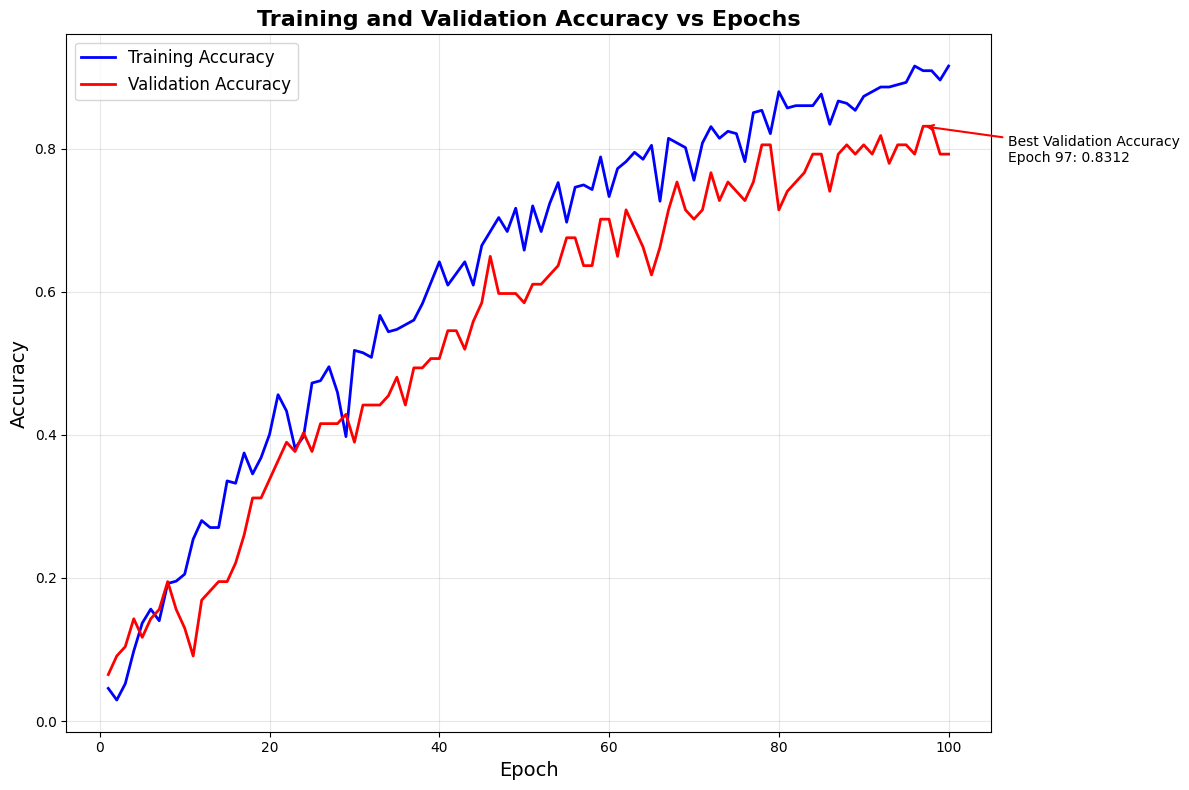

 Training completed in 100 epochs
 Best validation accuracy: 0.8312 at epoch 97
 Final training accuracy: 0.9153
 Final validation accuracy: 0.7922


In [25]:
# Plot 1: Training and Validation Accuracy vs Epochs

plt.figure(figsize=(12, 8))
epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.plot(epochs_range, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)

plt.title('Training and Validation Accuracy vs Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add annotations for key points
max_val_acc_epoch = np.argmax(history.history['val_accuracy']) + 1
max_val_acc = max(history.history['val_accuracy'])
plt.annotate(f'Best Validation Accuracy\nEpoch {max_val_acc_epoch}: {max_val_acc:.4f}', 
             xy=(max_val_acc_epoch, max_val_acc), 
             xytext=(max_val_acc_epoch + 10, max_val_acc - 0.05),
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
             fontsize=10, ha='left')

plt.tight_layout()
plt.show()

print(f" Training completed in {len(history.history['accuracy'])} epochs")
print(f" Best validation accuracy: {max_val_acc:.4f} at epoch {max_val_acc_epoch}")
print(f" Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f" Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

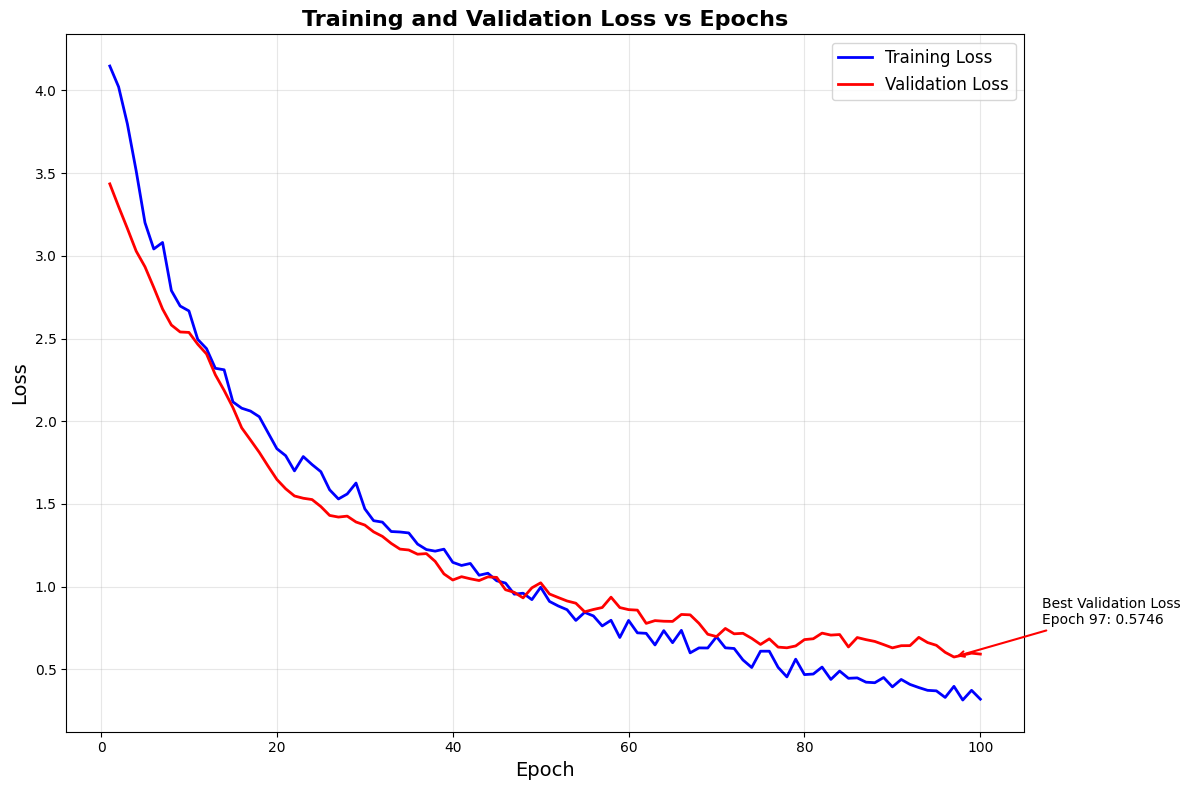

 Best validation loss: 0.5746 at epoch 97
 Final training loss: 0.3197
 Final validation loss: 0.5923


In [26]:
# Plot 2: Training and Validation Loss vs Epochs

plt.figure(figsize=(12, 8))
epochs_range = range(1, len(history.history['loss']) + 1)

plt.plot(epochs_range, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_range, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)

plt.title('Training and Validation Loss vs Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add annotations for key points
min_val_loss_epoch = np.argmin(history.history['val_loss']) + 1
min_val_loss = min(history.history['val_loss'])
plt.annotate(f'Best Validation Loss\nEpoch {min_val_loss_epoch}: {min_val_loss:.4f}', 
             xy=(min_val_loss_epoch, min_val_loss), 
             xytext=(min_val_loss_epoch + 10, min_val_loss + 0.2),
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
             fontsize=10, ha='left')

plt.tight_layout()
plt.show()

print(f" Best validation loss: {min_val_loss:.4f} at epoch {min_val_loss_epoch}")
print(f" Final training loss: {history.history['loss'][-1]:.4f}")
print(f" Final validation loss: {history.history['val_loss'][-1]:.4f}")

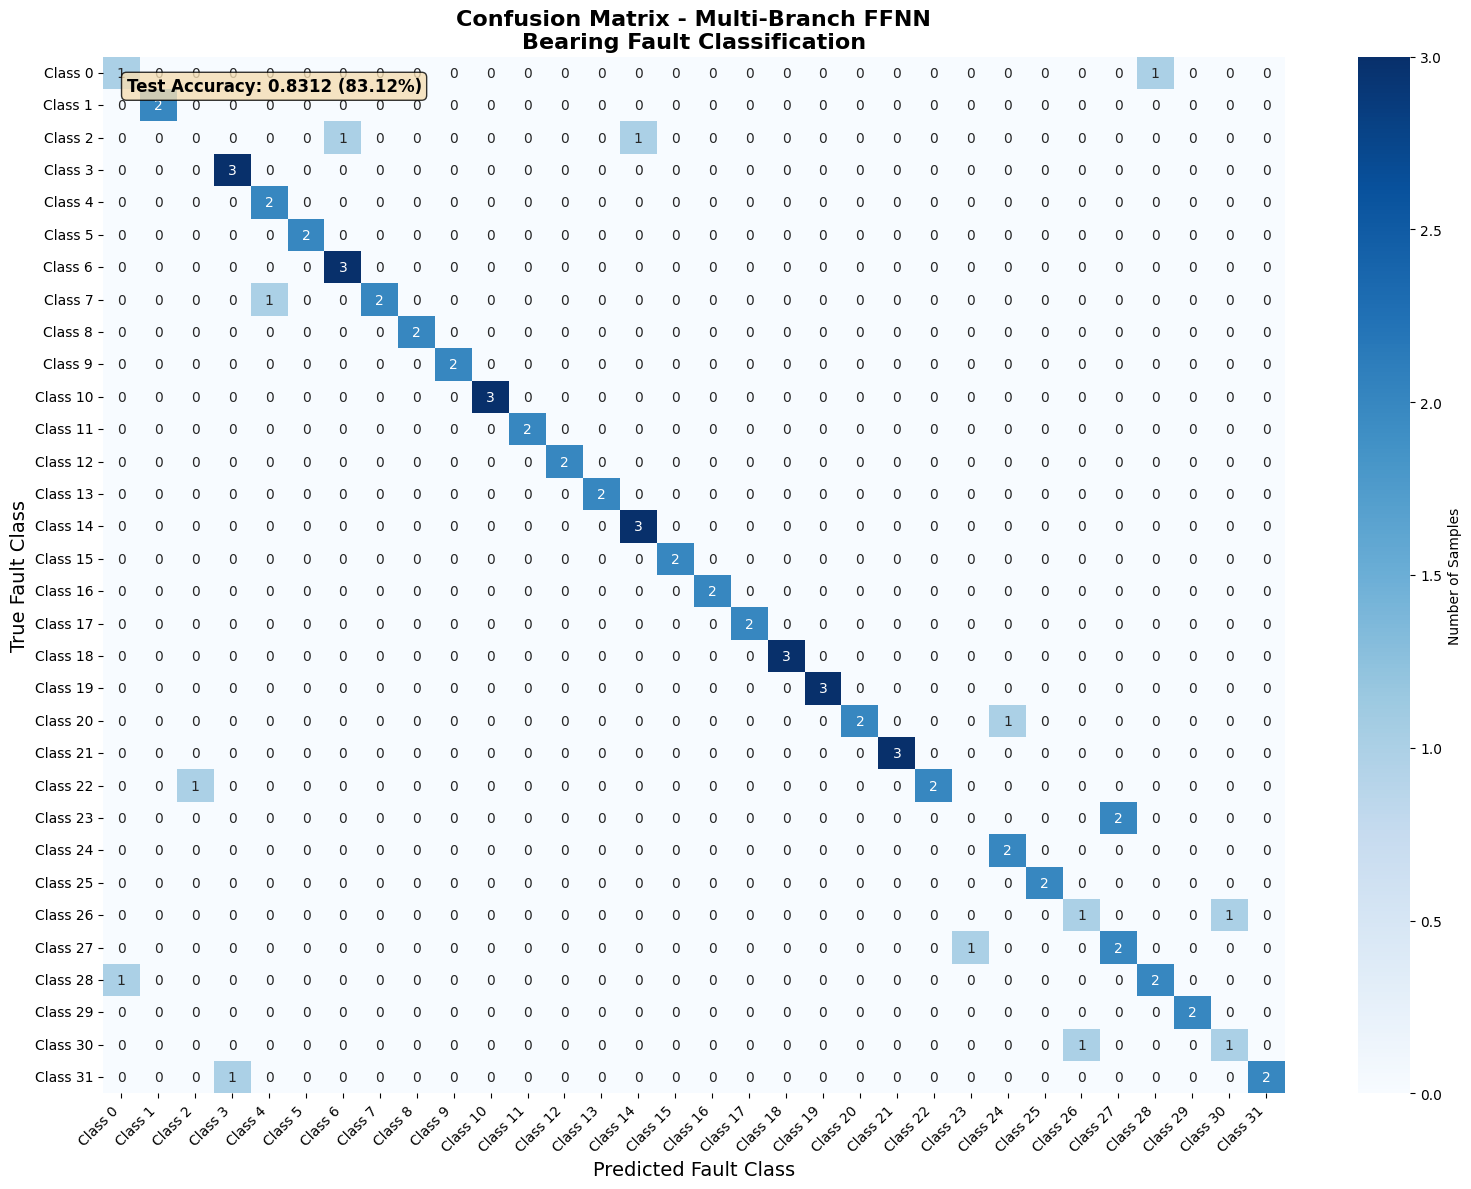


 Per-Class Accuracy Summary:
   Mean per-class accuracy: 0.8281
   Best performing class: Class 1 (1.0000)
   Worst performing class: Class 2 (0.0000)
   Classes with perfect accuracy: 21 out of 32


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Extract fault class labels from metadata (if available)
try:
    fault_classes = sorted(set(meta['fault_class'] for meta in metadata_384))
except:
    fault_classes = [f'Class {i}' for i in range(data_splits['num_classes'])]

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=fault_classes, yticklabels=fault_classes,
            cbar_kws={'label': 'Number of Samples'})

plt.title('Confusion Matrix - Multi-Branch FFNN\nBearing Fault Classification',
          fontsize=16, fontweight='bold')
plt.xlabel('Predicted Fault Class', fontsize=14)
plt.ylabel('True Fault Class', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Add test accuracy annotation
plt.text(0.02, 0.98,
         f'Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)',
         transform=plt.gca().transAxes,
         fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

# Per-class accuracy calculation
with np.errstate(divide='ignore', invalid='ignore'):
    per_class_accuracy = np.true_divide(cm.diagonal(), cm.sum(axis=1))
    per_class_accuracy = np.nan_to_num(per_class_accuracy)

# Display per-class accuracy summary
print(f"\n Per-Class Accuracy Summary:")
print(f"   Mean per-class accuracy: {np.mean(per_class_accuracy):.4f}")
print(f"   Best performing class: {fault_classes[np.argmax(per_class_accuracy)]} ({np.max(per_class_accuracy):.4f})")
print(f"   Worst performing class: {fault_classes[np.argmin(per_class_accuracy)]} ({np.min(per_class_accuracy):.4f})")
print(f"   Classes with perfect accuracy: {np.sum(per_class_accuracy == 1.0)} out of {len(fault_classes)}")

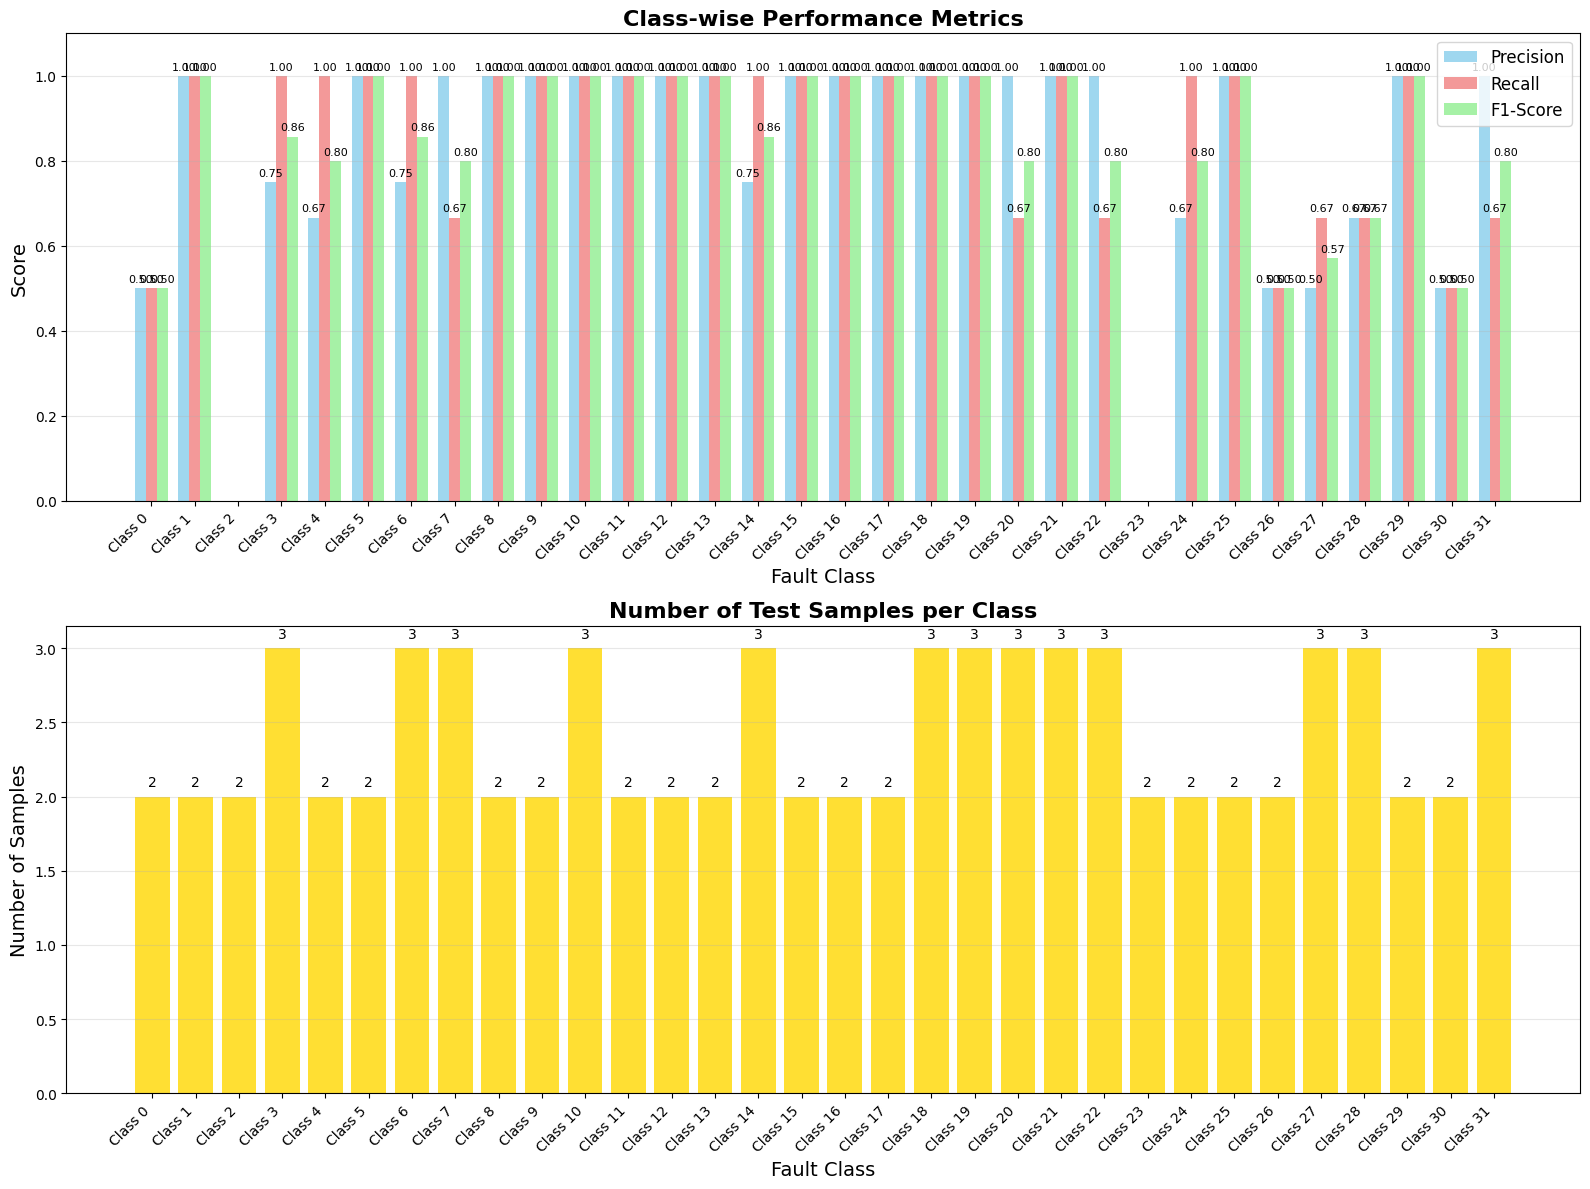

 CLASS-WISE PERFORMANCE STATISTICS:
   Average Precision: 0.8203 ± 0.2788
   Average Recall: 0.8281 ± 0.2779
   Average F1-Score: 0.8159 ± 0.2659
   Total Test Samples: 77
   Samples per Class: 2.4 (average)


In [28]:
# Plot 4: Class-wise Performance Metrics (Precision, Recall, F1-Score)

from sklearn.metrics import precision_recall_fscore_support

# Calculate per-class metrics
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_true, y_pred, average=None, zero_division=0)

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Bar chart for precision, recall, f1-score
x_pos = np.arange(len(fault_classes))
width = 0.25

bars1 = ax1.bar(x_pos - width, precision_per_class, width, label='Precision', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x_pos, recall_per_class, width, label='Recall', alpha=0.8, color='lightcoral')
bars3 = ax1.bar(x_pos + width, f1_per_class, width, label='F1-Score', alpha=0.8, color='lightgreen')

ax1.set_title('Class-wise Performance Metrics', fontsize=16, fontweight='bold')
ax1.set_xlabel('Fault Class', fontsize=14)
ax1.set_ylabel('Score', fontsize=14)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(fault_classes, rotation=45, ha='right', fontsize=10)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 1.1)

# Add value labels on bars
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=8)

add_value_labels(ax1, bars1)
add_value_labels(ax1, bars2)
add_value_labels(ax1, bars3)

# Plot 2: Support (number of samples per class)
bars4 = ax2.bar(x_pos, support_per_class, alpha=0.8, color='gold')
ax2.set_title('Number of Test Samples per Class', fontsize=16, fontweight='bold')
ax2.set_xlabel('Fault Class', fontsize=14)
ax2.set_ylabel('Number of Samples', fontsize=14)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(fault_classes, rotation=45, ha='right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on support bars
for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Performance statistics
print(f" CLASS-WISE PERFORMANCE STATISTICS:")
print(f"   Average Precision: {np.mean(precision_per_class):.4f} ± {np.std(precision_per_class):.4f}")
print(f"   Average Recall: {np.mean(recall_per_class):.4f} ± {np.std(recall_per_class):.4f}")
print(f"   Average F1-Score: {np.mean(f1_per_class):.4f} ± {np.std(f1_per_class):.4f}")
print(f"   Total Test Samples: {np.sum(support_per_class)}")
print(f"   Samples per Class: {np.sum(support_per_class) / len(fault_classes):.1f} (average)")

In [29]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Per-class accuracy
with np.errstate(divide='ignore', invalid='ignore'):
    per_class_accuracy = np.true_divide(cm.diagonal(), cm.sum(axis=1))
    per_class_accuracy = np.nan_to_num(per_class_accuracy)

# Print summary
print("\n Class-Wise Accuracy:")
for i, acc in enumerate(per_class_accuracy):
    print(f"  Class {i}: {acc:.4f}")
print(f"\n  Mean Accuracy: {np.mean(per_class_accuracy):.4f}")
print(f"  Best Class: {np.argmax(per_class_accuracy)} ({np.max(per_class_accuracy):.4f})")
print(f"  Worst Class: {np.argmin(per_class_accuracy)} ({np.min(per_class_accuracy):.4f})")


 Class-Wise Accuracy:
  Class 0: 0.5000
  Class 1: 1.0000
  Class 2: 0.0000
  Class 3: 1.0000
  Class 4: 1.0000
  Class 5: 1.0000
  Class 6: 1.0000
  Class 7: 0.6667
  Class 8: 1.0000
  Class 9: 1.0000
  Class 10: 1.0000
  Class 11: 1.0000
  Class 12: 1.0000
  Class 13: 1.0000
  Class 14: 1.0000
  Class 15: 1.0000
  Class 16: 1.0000
  Class 17: 1.0000
  Class 18: 1.0000
  Class 19: 1.0000
  Class 20: 0.6667
  Class 21: 1.0000
  Class 22: 0.6667
  Class 23: 0.0000
  Class 24: 1.0000
  Class 25: 1.0000
  Class 26: 0.5000
  Class 27: 0.6667
  Class 28: 0.6667
  Class 29: 1.0000
  Class 30: 0.5000
  Class 31: 0.6667

  Mean Accuracy: 0.8281
  Best Class: 1 (1.0000)
  Worst Class: 2 (0.0000)
